# Прогноз оттока клиентов оператора связи

Оператор связи хочет научиться прогнозировать отток клиентов. Стоимость маркетинговых затрат на возврат ушедшего клиента весьма высока, дешевле удержать клиента. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

**Цель исследования** 

Необходимо спрогнозировать, уйдёт клиент от оператора в ближайшее время или нет, т.е. построить модель для задачи классификации. Для оценки качества моделей применим метрику AUC-ROC. Значение метрики AUC-ROC должно быть больше 0.88.

**Ход исследования**

Команда оператора собрала и предоставила нам персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Информация о договорах актуальна на 1 февраля 2020. Прежде чем приступить к построению модели, проверим их на корректность.

Таким образом, исследование пройдёт по следующим этапам:
1.	Предварительный анализ:
*	загрузить и убедиться в валидности данных;
*	обработать данные для корректной работы в Питоне (тип данных, общий датасет);
2.	Анализ данных:
*	определить признаки и целевой признак, добавить синтетические признаки;
*	выполнить предобработку признаков при необходимости;
*	исследовательский анализ данных;
3.	Подготовить данные:
*	проверка мультиколлинеарности;
*	выполнить предобработку признаков при необходимости (кодирование, масштабирование и др.);
*	определить тестовую и тренировочную выборки;
4.	Построить и обучить модели:
*	выбрать модели и их гиперпараметры;
*	обучить модели и получить метрики качества предсказаний на тренировочной выборке;
*	выбрать лучшую модель и ее гиперпараметры;
5.	Выполнить анализ модели:
*	получить метрики качества предсказаний на тестовой выборке выбранной предобученной модели;
*	сравнить полученные метрики качества модели с заданием;
6.	Подготовка отчета по исследованию:
*	отразить основные этапы исследования;
*	аргументировать выбор модели;
*	представить сводную таблицу по всем рассмотренным моделям.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

## Предварительный анализ

**Открытие файлов. Общее представление**

Импортируем библиотеки для работы в Питоне.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from imblearn.over_sampling import SMOTE 

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from catboost import CatBoostClassifier, cv, Pool

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

Откроем файлы с данными и изучим общую информацию. Прочитаем файлы и сохраним его в датасет.

### Информация о договоре

In [6]:
try: 
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
except: 
    contract = pd.read_csv('contract.csv')

In [7]:
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Согласно документации к данным:
* BeginDate – дата начала пользования услугами,
* EndDate – дата окончания пользования услугами,
* Type – тип оплаты: ежемесячный, годовой и тд,
* PaperlessBilling – безналичный расчет,
* PaymentMethod – способ оплаты,
* MonthlyCharges – ежемесячные траты на услуги,
* TotalCharges – всего потрачено денег на услуги

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Посчитаем количество уникальных клиентов.

In [9]:
contract['customerID'].value_counts()

7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

В предоставленном файле информация о контрактах с 7043 клиентами. Тип данных во всех столбцах — object, кроме MonthlyCharges - float.

В названиях колонок имеется нарушения стиля. Приведем эти названия к "змеиному" регистру.

In [10]:
# convert columns name to snake case

contract.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in contract.columns]
contract.columns.to_list()

['customer_i_d',
 'begin_date',
 'end_date',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges']

In [11]:
contract = contract.rename(columns={'customer_i_d':'customer_id'})

Найдем долю клиентов, которые ушли к другому оператору. Будем соотносить их к классу "1". Фактически это целевой признак, который необходимо предсказать модели.

In [12]:
share_clients = 1 - contract.query('end_date=="No"')['customer_id'].count() / contract.shape[0]
print(f'Доля ушедших клиентов: {share_clients:.1%}')

Доля ушедших клиентов: 26.5%


Класс "1" встречается реже, доля составляет только 26.5%. Классы не сбалансированы, когда их соотношение далеко от 1:1. Необходимо учесть дисбаланс при обучении модели, возможно применить семплирование признаков или задать соотвествующие параметры модели.

Переведем тип данных столбца total_charges в float для оценки распределения значений.

In [13]:
# convert type of feature to float

contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Колонка total_charges теперь float, но в ней появились пропуски. Посмотрим на данные объекты.

In [14]:
# items with NaN
contract[contract['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Подобные клиенты только заключили договор с оператором. Видимо система не заполняет колонку total_charges в течение первого месяца пользования услугами связи. Продублируем значения из соседнего столбца monthly_charges на месте пропусков.

In [15]:
# fillna for total_charges
contract['total_charges'] = contract['total_charges'].fillna(contract['monthly_charges'])

Подробнее изучим распределение значений методом describe.

In [16]:
contract.describe()

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2279.798992
std,30.090047,2266.730170
min,18.250000,18.800000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


Расходы клиентов, в общем случае, принимают следующие значения:
* Ежемесячно. Платежи не превышают значения 90. Медиана совсем немного больше среднего значения;
* Суммарно за все время. Платежи не превышают значения 3787. Медиана меньше среднего в 1.6 раза;

Построим диаграммы значений для признака - monthly_charges.

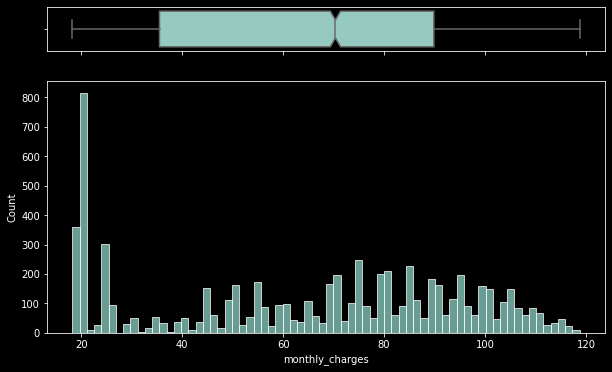

In [17]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
plt.style.use('dark_background')
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    figsize=(10, 6), 
                                    gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(contract['monthly_charges'], notch=1, ax=ax_box)
sns.histplot(data=contract, x='monthly_charges', bins=70, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='');

График распределения скошен больше влево. Можно выделить пики значений расходов клиентов в диапазоне от 18 до 30. Явные аномалии здесь не обнаружены.

Построим диаграммы значений для признака - total_charges.

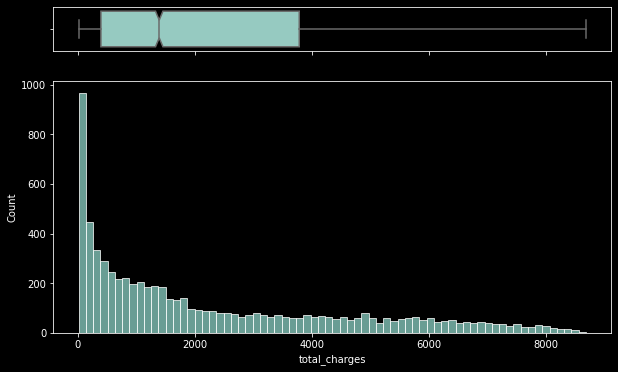

In [18]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10, 6), 
                                    gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(contract['total_charges'], notch=1, ax=ax_box)
sns.histplot(data=contract, x='total_charges', bins=70,  ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='');

График формой напоминает распределение Пуассона, скошен вправо. Можно выделить пик значений расходов клиентов около 18. Явные аномалии здесь не обнаружены.

Посмотрим какие значения принимают категориальные признаки.

In [19]:
# categorical variables

for col in contract.select_dtypes(object).columns:
    if col != "customer_id":
        print()
        # to print count of every category
        print(contract[col].value_counts()) 
        print('-------------')


2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: begin_date, Length: 77, dtype: int64
-------------

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64
-------------

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64
-------------

Yes    4171
No     2872
Name: paperless_billing, dtype: int64
-------------

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64
-------------


Категориальные признаки принимают значения:
* begin_date. 77 уникальных значений.
* end_date. 4 уникальных значения. Отток клиентов начался только с октября 2019 г, пик в ноябре.
* type. 3 уникальных значения. Клиенты предпочитают помесячную тарификацию.
* paperless_billing. бинарный признак. Большинство оплачивает по безналу.
* payment_method. 4 уникальных значения. Клиенты в основном выбирают электронные платежи.

**Вывод**

Отметим следующие группы признаков для обучения модели:
* Категориальные - type, paperless_billing, payment_method.
* Числовые - monthly_charges, total_charges. Также возможно посчитать длительность договора по разнице begin_date и end_date (если договор действующий, то расчет до 1 февраля 2020).
* Целевой признак - колонка end_date. 0 - для значений 'No', 1 - для ушедших клиентов, значения с датой.

### Персональные данные клиента

In [21]:
try: 
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
except: 
    personal = pd.read_csv('personal.csv')

personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Согласно документации к данным:
* gender - пол клиента
* Dependents – наличие иждивенцев
* Senior Citizen – наличие пенсионного статуса по возрасту
* Partner – наличие супруга(и)

In [22]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Посмотрим какие значения принимают признаки.

In [23]:
# count of features

for col in personal.columns:
    print()
    print(personal[col].value_counts()) 
    print('-------------')


7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64
-------------

Male      3555
Female    3488
Name: gender, dtype: int64
-------------

0    5901
1    1142
Name: SeniorCitizen, dtype: int64
-------------

No     3641
Yes    3402
Name: Partner, dtype: int64
-------------

No     4933
Yes    2110
Name: Dependents, dtype: int64
-------------


В предоставленном файле информация о 7043 клиентах. Тип данных во всех столбцах — object, кроме SeniorCitizen - int.

Категориальные признаки в общем случае принимают значения:
* Мужчин немного больше, чем женщин.
* Большинство - без детей.
* Клиентов пенсионного статуса меньшинство.
* Незамужних - чуть больше.

В названиях колонок имеется нарушения стиля. Приведем эти названия к "змеиному" регистру.

In [24]:
# convert columns name to snake case

personal.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in personal.columns]
personal.columns.to_list()

['customer_i_d', 'gender', 'senior_citizen', 'partner', 'dependents']

In [25]:
personal = personal.rename(columns={'customer_i_d':'customer_id'})

Переведем численные значения признака senior_citizen в 'Yes'/'No' для однородности представления данных.

In [26]:
# convert integer values to object
personal['senior_citizen'] = personal['senior_citizen'].map({1: 'Yes', 0:'No'})

Проверим, какие теперь значения у признака senior_citizen.

In [27]:
personal['senior_citizen'].value_counts()

No     5901
Yes    1142
Name: senior_citizen, dtype: int64

Распределение значений сохранилось. Операция выполнена корректно.

**Вывод**

Отметим следующие группы признаков для обучения модели:
* Категориальные - gender, senior_citizen, partner, dependents. Все признаки бинарного характера.

### Информация об интернет-услугах

In [29]:
try: 
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
except: 
    internet = pd.read_csv('internet.csv')

internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Оператор предоставляет Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

In [30]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Посмотрим какие значения принимают признаки.

In [31]:
# count of features

for col in internet.columns:
    print()
    print(internet[col].value_counts()) # to print count of every category
    print('-------------')


7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: customerID, Length: 5517, dtype: int64
-------------

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64
-------------

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64
-------------

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64
-------------

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64
-------------

No     3473
Yes    2044
Name: TechSupport, dtype: int64
-------------

No     2810
Yes    2707
Name: StreamingTV, dtype: int64
-------------

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64
-------------


В предоставленном файле информация об интернет-услугах для 5517 клиентов. Тип данных во всех столбцах — object.

Клиенты, в общем случае, предпочитают оптоволкно для соединения, без услуг интернет-безопасности, без линии тех. поддержки и без облачного хранилища. Пользователей стриминговых сервисов (телевидение и фильмы) чуть меньше.

В названиях колонок имеется нарушения стиля. Приведем эти названия к "змеиному" регистру.

In [32]:
# convert columns name to snake case

internet.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in internet.columns]
internet.columns.to_list()

['customer_i_d',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_t_v',
 'streaming_movies']

In [33]:
internet = internet.rename(columns={'customer_i_d':'customer_id', 'streaming_t_v':'streaming_tv'})

**Вывод**

Отметим следующие группы признаков для обучения модели:
* Категориальные - internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies. Все признаки бинарного характера.

Можно определить по количеству объектов, что не все клиенты пользуются услугами интернета от оператора.

### Информация об услугах телефонии

In [35]:
try: 
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except: 
    phone = pd.read_csv('phone.csv')

phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Оператор предоставляет стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно (MultipleLines).

In [36]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Посмотрим какие значения принимают признаки.

In [37]:
# count of features

for col in phone.columns:
    print()
    print(phone[col].value_counts()) # to print count of every category
    print('-------------')


5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: customerID, Length: 6361, dtype: int64
-------------

No     3390
Yes    2971
Name: MultipleLines, dtype: int64
-------------


В предоставленном файле информация об услугах телефонии для 6361 клиента. Тип данных во всех столбцах — object.

Болшинство клиентов не пользуется услугами MultipleLines.

В названиях колонок имеется нарушения стиля. Приведем эти названия к "змеиному" регистру.

In [38]:
# convert columns name to snake case

phone.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in phone.columns]
phone.columns.to_list()

['customer_i_d', 'multiple_lines']

In [39]:
phone = phone.rename(columns={'customer_i_d':'customer_id'})

**Вывод**

Отметим следующие группы признаков для обучения модели:
* Категориальные - multiple_lines. Признак бинарного характера.

Можно определить по количеству объектов, что не все клиенты пользуются услугами телефоной связи от оператора.

## Анализ данных

### Целевой признак

Признак, который нужно предсказать, — целевой (target): в предоставленных данных на это указывает колонка end_date, дата закрытия договора между клиентом и оператором. Класс "0" - для значений 'No', класс "1" - для ушедших клиентов, значения с датой. Создадим новый столбец churn, в который укажем класс для каждого клиента из данных contract.

In [40]:
# target definition to new column churn
contract['churn'] = (contract['end_date'] != 'No').astype(int)
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


Проверим баланс классов. Убедимся, что изменение прошло корректно.

In [41]:
# balance of target classes
contract['churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: churn, dtype: float64

Дисбаланс сохранился в той же пропорции. Класс "1" встречается реже, доля составляет только 26.5%. 

Рассмотрим следующие варианты решений проблемы дисбаланса в нашем исследовании: 
* оставить признаки с дисбалансом (пропорции граничного харктера 1:3);
* использовать метод семплирования, увеличить число объектов редкого класса;
* применить настройки модели для несбалансированной обучающей выборки.

Выполним обучение модели согласно предложенным вариантам и выберем лучшую по метрики качества предсказаний.

### Синтетические признаки и общий датасет

Добавим синтетические признаки, т.е. определим расчетные харктеристики клиентов, основанные на исходных данных.

#### Даты договора

Отредактируем столбец end_date для удобства расчетов и анализа данных. Укажем дату выгрузки данных 1 февраля 2020 для объектов со значение 'No'.

In [42]:
# edit end_date
contract['end_date'] = contract['end_date'].replace('No', '2020-02-01')
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


Изменение прошло корректно.

Переведем тип данных столбцов begin_date и end_date в datetime для работы с датами в Питоне.

In [43]:
# transfer begin_date to datetime format
contract['begin_date'] = pd.to_datetime(contract['begin_date'], 
                                        format='%Y-%m-%d')
print(contract['begin_date'].dtype)

datetime64[ns]


In [44]:
# transfer end_date to datetime format
contract['end_date'] = pd.to_datetime(contract['end_date'], 
                                      format='%Y-%m-%d')
print(contract['end_date'].dtype)

datetime64[ns]


Тип данных для признаков с датами изменился на datetime.

Посчитаем длительность договора в месяцах по разнице begin_date и end_date с помощью функции months. Функция выполнит вычисления и запишет результат в новый столбец months.

In [45]:
# function of contract duration calculation in months

def months(row):
  months = (row['end_date'].year - row['begin_date'].year) * 12 + row['end_date'].month - row['begin_date'].month
  return months

Применим полученную функцию и проверим столбец duration.

In [46]:
# apply function into new column 'months'
contract['months'] = contract.apply(months, axis=1) 

contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,months
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2


Функция провела вычисления корректно.

Теперь посчитаем длительность договора в днях по разнице begin_date и end_date. Результат запишем в новый столбец days. 

In [47]:
# contract duration calculation in days

contract['days'] = (contract['end_date'] - contract['begin_date']).dt.days
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,months,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,34,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,61


Появилось два синтетических признака в данных, но они очевидно зависимы друг от друга. Необходимо учесть это на этапе проверки мультиколлинеарности, когда будем подготавливать обучающую выборку. 

#### Количество сервисов

Информация об интернет-услугах содержит данные о разных подключенных опциях. Преобразуем такие признаки в целочисленный формат (подключено - 1, отключено - 0). Определим новый признак - количество подключенных услуг у клиента.

In [48]:
# list of services
list_servs = []
df_servs = internet.copy()

# convert object type to integer
for col in internet.columns: 
    if col not in ("customer_id", "internet_service"):
        list_servs.append(col)
        df_servs[col] = df_servs[col].map({'Yes': 1, 'No': 0}).astype(int)

In [49]:
# quantity of internet services
internet['servs'] = df_servs[list_servs].sum(axis=1)

In [50]:
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,servs
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,1
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,2
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,2
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,3
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,0


Расчет выполнен корректно. Появился новый синтетический признак.

#### Общий датасет

Соберем все признаки для работы модели в один датасет telecom. Присоединим все данные методом merge по столбцу customer_id. Отберем 21 признак, определенных раннее:
* Категориальные - type, paperless_billing, payment_method, gender, senior_citizen, partner, dependents, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines, servs.
* Числовые - monthly_charges, total_charges, months, days. 
* Целевой признак - churn.

Признаки begin_date и end_date не нужны, т.к. они участвовали в вычислении длительности контракта. Использование end_date приведет к утечке целевого признака. Колонку customer_id необходима только для объединения данных.

In [51]:
# collect all features in one dataframe

telecom = contract.drop(['begin_date', 'end_date'], axis=1)
telecom = telecom.merge(personal, on='customer_id')
telecom = telecom.merge(internet, on='customer_id', how='left')
telecom = telecom.merge(phone, on='customer_id', how='left')
telecom = telecom.drop(['customer_id'], axis=1)

telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   churn              7043 non-null   int64  
 6   months             7043 non-null   int64  
 7   days               7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   object 
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

Данные объединены корректно, мы получили информацию для 7043 клиентов по 21 признаку. Т.к. не все клиенты пользуются услугами интернета или телефонии, появились пропущенные значения в данных. 

#### Категории сервисов

Определим категорию клиента по видам услуг: телефония, интернет или обе. Получим новый признак `option` - подключенные опции.

In [52]:
# option definition if values is Nan

telecom.loc[telecom['internet_service'].isnull(), 'option'] = 'phone'
telecom.loc[telecom['multiple_lines'].isnull(), 'option'] = 'internet'
telecom['option'].fillna('both', inplace=True)

Проверим правильность полученного признака.

In [53]:
telecom[['internet_service', 'multiple_lines', 'option']].sample(5)

,internet_service,multiple_lines,option
1902,DSL,Yes,both
1573,Fiber optic,No,both
5544,Fiber optic,Yes,both
5946,DSL,No,both
6225,Fiber optic,Yes,both


Определение категории выполнено корректно. Появился новый синтетический признак.

Логично заменить пропущенные значения на 'No net', а для multiple_lines на 'No phone', т.е. услуга не подключена. Выполним замену и проверим количество пропусков. 

In [54]:
# filling NaN
telecom['multiple_lines'] = telecom['multiple_lines'].fillna('No phone')
telecom = telecom.fillna('No net')

# quantity of NaN
telecom.isna().sum()

type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
months               0
days                 0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
servs                0
multiple_lines       0
option               0
dtype: int64

Теперь пропуски в данных отсутствуют.

Найдем количество дубликатов в данных.

In [55]:
# quantity of duplicates
print('Количество явных дубликатов:', telecom.duplicated().sum()) 

Количество явных дубликатов: 18


Удалим дубликаты из данных. Выполним проверку повторно.

In [56]:
# remove duplicates
telecom = telecom.drop_duplicates()

# quantity of duplicates
print('Количество явных дубликатов:', telecom.duplicated().sum())

Количество явных дубликатов: 0


Посмотрим на размер обновленных данных.

In [57]:
telecom.shape

(7025, 22)

Число объектов сократилось на 18.

#### Категория по длительности договора

Построим гистограмму распределение значений для признака "длительность договора в месяцах" в процентном соотношении, сгладим дискретные интервалы с помощью кривой KDE.

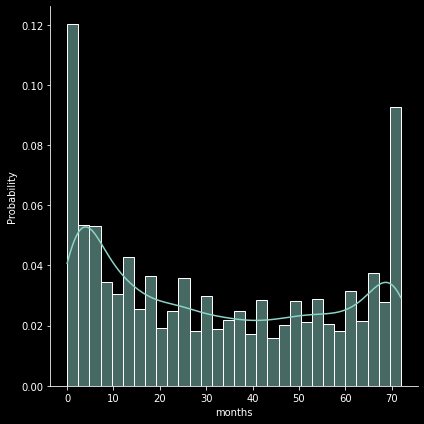

In [58]:
# distribution of months values
sns.displot(telecom['months'], bins=30, stat='probability', height=6, kde=True);

На полученном графике можно выделить характерные интервалы значений:
* до 5 мес. Новые пользователи.
* до 12 мес. Короткая длительность договора.
* до 55 мес. Средняя длительность договора.
* более 55 мес. Большая длительность договора.

Запишем эти категории в отдельный признак для клиента - `tenure`.

In [59]:
# list of categories
tenure_labels = ['New', 'Short', 'Normal', 'Long']
tenure_bins = [0, 5, 12, 55, 72]

# category definition
telecom['tenure'] = pd.cut(telecom['months'],
                       bins=tenure_bins,
                       labels=tenure_labels)

Проверим наличие пропусков в признаке, все ли значения заполнены.

In [60]:
# clients with NaN in tenure
telecom[telecom['tenure'].isna()]

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,months,days,gender,senior_citizen,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,servs,multiple_lines,option,tenure
488,Two year,Yes,Bank transfer (automatic),52.55,52.55,0,0,0,Female,No,...,Yes,No,Yes,Yes,Yes,No,4.0,No phone,internet,NaN
753,Two year,No,Mailed check,20.25,20.25,0,0,0,Male,No,...,No net,No net,No net,No net,No net,No net,No net,No,phone,NaN
936,Two year,No,Mailed check,80.85,80.85,0,0,0,Female,No,...,Yes,Yes,Yes,No,Yes,Yes,5.0,No,both,NaN
1082,Two year,No,Mailed check,25.75,25.75,0,0,0,Male,No,...,No net,No net,No net,No net,No net,No net,No net,Yes,phone,NaN
1340,Two year,No,Credit card (automatic),56.05,56.05,0,0,0,Female,No,...,Yes,Yes,Yes,Yes,Yes,No,5.0,No phone,internet,NaN
3331,Two year,No,Mailed check,19.85,19.85,0,0,0,Male,No,...,No net,No net,No net,No net,No net,No net,No net,No,phone,NaN
3826,Two year,No,Mailed check,25.35,25.35,0,0,0,Male,No,...,No net,No net,No net,No net,No net,No net,No net,Yes,phone,NaN
4380,Two year,No,Mailed check,20.00,20.00,0,0,0,Female,No,...,No net,No net,No net,No net,No net,No net,No net,No,phone,NaN
5218,One year,Yes,Mailed check,19.70,19.70,0,0,0,Male,No,...,No net,No net,No net,No net,No net,No net,No net,No,phone,NaN
6670,Two year,No,Mailed check,73.35,73.35,0,0,0,Female,No,...,No,Yes,Yes,Yes,Yes,No,4.0,Yes,both,NaN


Есть пропуски для новых клиентов, которые только подключились к оператору. Заполним их категорией "New".

In [61]:
# fill NaN
telecom['tenure'] = telecom['tenure'].fillna('New')

In [62]:
# clients with NaN in tenure
telecom[telecom['tenure'].isna()]

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,months,days,gender,senior_citizen,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,servs,multiple_lines,option,tenure


Пропуски отсутствуют. Проверим значения полученного признака.

In [63]:
telecom[['months', 'tenure']].sample(5)

,months,tenure
5027,10,Short
4006,72,Long
6614,71,Long
4561,8,Short
2745,1,New


Определение категории выполнено корректно. Появился новый синтетический признак.

#### Категория по платежам

Построим гистограмму распределения значений для признака "ежемесячные платежи" в процентном соотношении, сгладим дискретные интервалы с помощью кривой KDE.

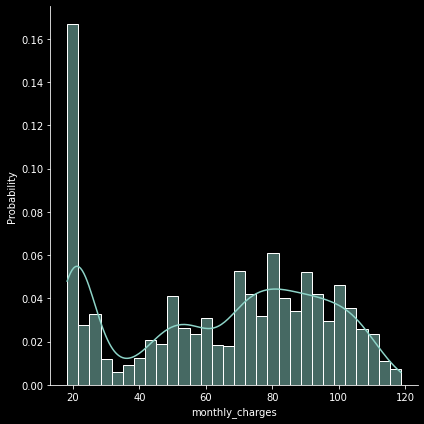

In [64]:
# distribution of months values
sns.displot(telecom['monthly_charges'], bins=30, stat='probability', height=6, kde=True);

На полученном графике можно выделить характерные интервалы значений:
* до 30. Небольшые расходы.
* до 65. Средние расходы..
* более 65 мес. Высокие расходы.

Запишем эти категории в отдельный признак для клиента - `charges`.

In [65]:
# list of categories
tenure_labels = ['Low', 'Middle', 'High']
tenure_bins = [0, 30, 65, 120]

# category definition
telecom['charges'] = pd.cut(telecom['monthly_charges'],
                       bins=tenure_bins,
                       labels=tenure_labels)

Проверим правильность полученного признака.

In [66]:
telecom[['monthly_charges', 'charges']].sample(5)

,monthly_charges,charges
4848,93.9,High
5472,81.0,High
732,75.5,High
1278,60.7,Middle
4280,19.7,Low


Определение категории выполнено корректно. Появился новый синтетический признак.

Посмотрим на размер обновленных данных.

In [67]:
telecom.shape

(7025, 24)

Число столбцов увеличилось на 4 за счет добавления синтетических признаков.

### Исследовательский анализ данных

#### Числовые признаки

Подробнее изучим распределение числовых значений для ушедших клиентов. Построим диаграммы значений для каждого такого признака c помощью функции. 

In [68]:
# function of diagramms for numeric values
def plot_num(df, list):

    # size for output figure
    cols = len(list)
    rows = 2
    plt.figure(figsize=(20, 10))
    idx = 0

    # histogramm
    for col in list:       
        idx += 1 
        plt.subplot(rows, cols, idx)
        plt.hist(df[col], bins=20)
        plt.title(col)
    
    # boxplot
    for col in list:
        idx += 1 
        c = 'cyan'
        plt.subplot(rows, cols, idx)
        plt.boxplot(df[col], notch=True, patch_artist=True,
                    capprops=dict(color=c), whiskerprops=dict(color=c), 
                    flierprops=dict(markeredgecolor=c))
        plt.title(col);

Определим список числовых признаков numeric_features и применим функцию для ушедших клиентов.

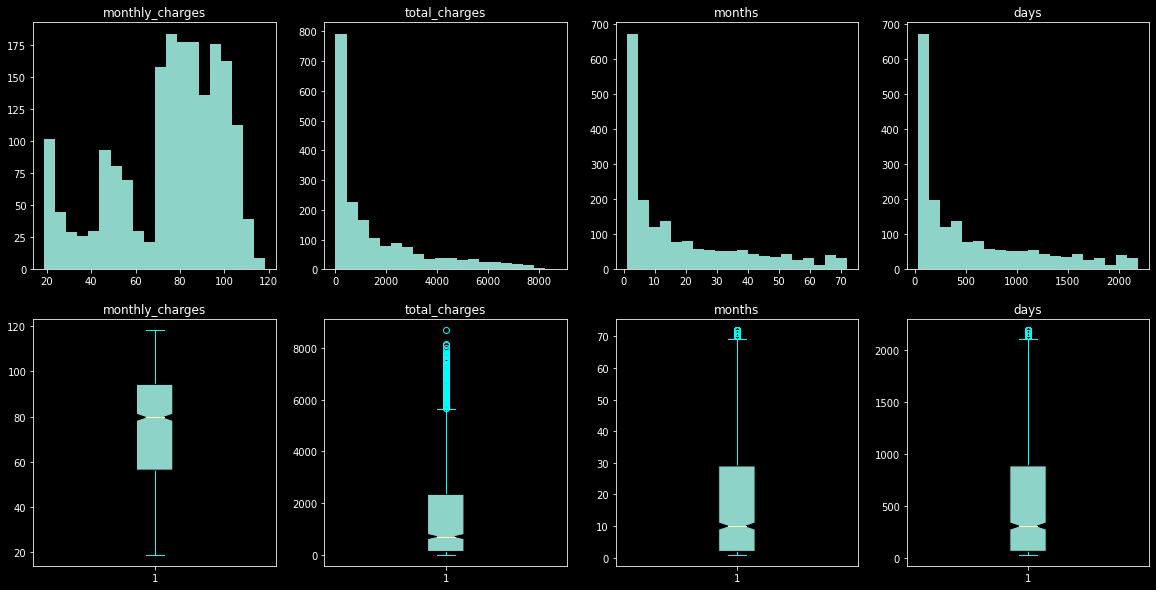

In [69]:
# specify numeric features
numeric_features = ['monthly_charges', 'total_charges','months', 'days']

# apply function of diagramms
plot_num(telecom.query('churn==1'), numeric_features)

Изучим распределение значений методом describe.

In [70]:
telecom.query('churn==1')[numeric_features].describe()

,monthly_charges,total_charges,months,days
count,1861.000000,1861.000000,1861.000000,1861.000000
mean,74.540865,1538.160451,18.052123,549.573348
std,24.622202,1892.384292,19.541243,594.697583
min,18.850000,18.850000,1.000000,30.000000
25%,56.250000,139.050000,2.000000,61.000000
50%,79.650000,712.850000,10.000000,304.000000
75%,94.250000,2342.200000,29.000000,883.000000
max,118.350000,8684.800000,72.000000,2191.000000


Числовые признаки ушедших клиентов, в общем случае, принимают следующие значения:
* Ежемесячные платежи. Платежи принимают значения от 56 до 95. Медиана совсем немного больше среднего значения. Клиенты платят в среднем 80, что дает нам предположить о возможной причине ухода, как высокие затраты на услуги. Также стоит отметить, что имеются пики около 20 и 50. Можно выделить 3 группы пользователей по этим значениям. 
* Суммарные платежи. Платежи принимают значения от 140 до 2343. Значения около 6000 и выше - выбросы, случаются редко. Медиана меньше среднего в 2 раза. Клиенты платят в среднем 713. Пик от 19 до 140, потом идет резкое снижение показателя. Вероятно, что большое число клиентов уходят в первые месяцы пользования услугами.
* Длительность договора принимают значения от 2 до 29 месяцев. Медиана меньше среднего в 1.8 раза. Клиенты уходят в среднем после 10 месяцев. Значения около 70 и больше - выбросы, случаются редко. Пик значений до 5 показывает, что много клиентов уходит в первые месяца пользования услугами. Можно предположить, что если пользователи не ушли в первые месяцы, то они с большой вероятностью останутся.
* Длительность договора в днях соотвествуют распределению по месяцам.

Сформулируем гипотезы на основе полученных данных:
1. Ушедшие клиенты ежемесячно платят больше лояльных.
2. Клиенты в основном уходят в первые месяцы пользования услугами.

Проверим эти две гипотезы. Построим гистограмму распределения значений для признаков в процентном соотношении, сравним категории лояльности клиентов.

In [71]:
# function of displot for numeric values
def dist_num(df, list):

    for idx, column in enumerate(list):
        plt.figure(idx)
        sns.displot(data=df, x=column, hue='churn', stat='probability', 
                    height=5, legend=0, palette='Dark2')
        plt.xlabel(column, fontsize='large')
        plt.legend(title='Clients', labels=['Left', 'Loyal']);

<Figure size 432x288 with 0 Axes>

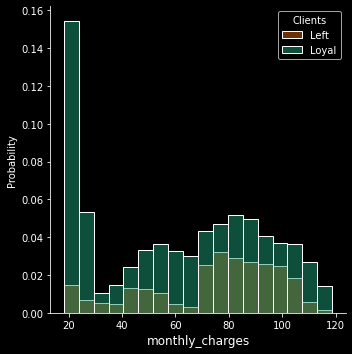

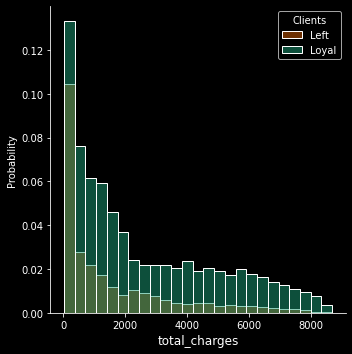

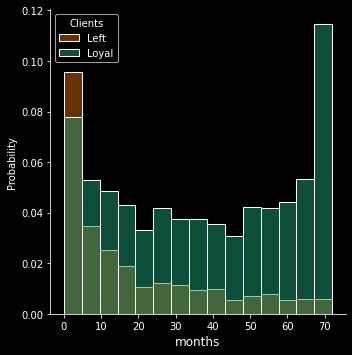

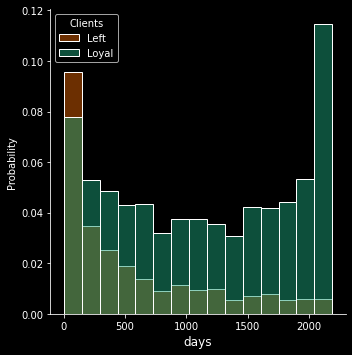

In [72]:
dist_num(telecom, numeric_features)

Числовые признаки клиентов, в общем случае, имеют следующие распределения:
* Ежемесячные платежи. Ушедшие клиенты платили больше - пик значений около 80. Лояльные пользователи более бережливые - пик около 20. 
* Суммарные платежи ушедших клиентов меньше, видимо за счет меньшего времени пользования услугами оператора.
* Длительность договора в месяцах. Большинство клиентов уходят в первые месяцы пользования, а те кто сотрудничает с оператором больше 20 месяцев - редкость. Оператор имеет большое число лояльных клиентов, которые пользуются услугами на протяжении 50-70 месяцев.
* Длительность договора в днях соотвествуют распределению по месяцам.

Гипотезы 1 и 2 подтвердились.

Построим гистограмму распределения значений для признака months в процентном соотношении, сравним категории лояльности клиентов.

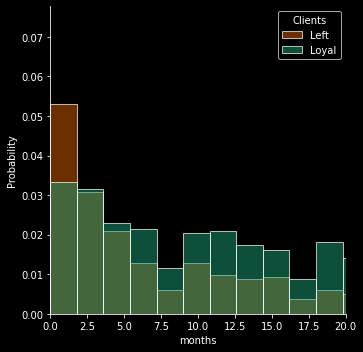

In [73]:
# displot for values of months
sns.displot(data=telecom, x='months', hue='churn', stat='probability', 
            height=5, legend=0, bins=40, palette='Dark2')
plt.legend(title='Clients', labels=['Left', 'Loyal'])

# axis x limit 
plt.xlim(0, 20);

Получили большую вероятность ухода клиента в первые 2 месяца. При более длительном пользовании услугами вероятность ухода заметно уменьшается.

Проверим также гипотезы с помощью диаграмм размаха и посмотрим на распределения медианных значений.

In [74]:
# function of boxplot for numeric values
def box_num(df, list):

    for idx, column in enumerate(list):
        plt.figure(idx)
        sns.boxplot(data=df, y=column, x='churn', 
                    notch=True, palette='Dark2');

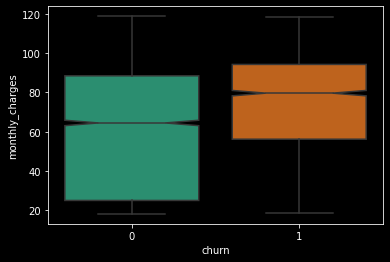

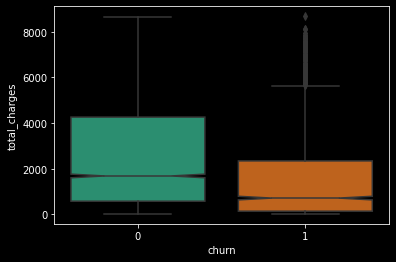

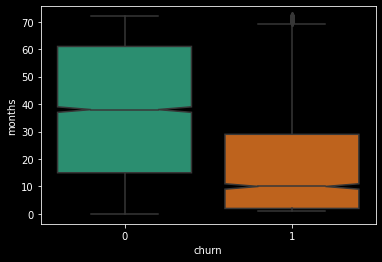

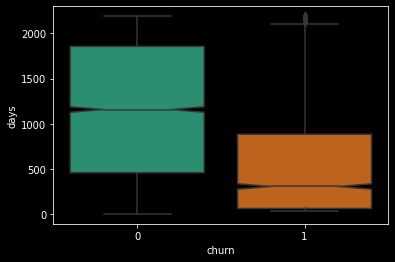

In [75]:
box_num(telecom, numeric_features)

Диаграмма размаха иллюстрирует следующие средние значения по медиане:
* Ежемесячные платежи. Ушедшие клиенты платили больше - около 80. Лояльные пользователи более бережливые - около 65. 
* Суммарные платежи ушедших клиентов меньше - до 6000, видимо за счет меньшего времени пользования услугами оператора. Лояльные пользователи в сумме платят больше - до 8500.
* Длительность договора в месяцах. Большинство клиентов уходят в первые месяцы пользования - до 10 месяцев, а те кто сотрудничает с оператором больше 30 месяцев - редкость. Оператор имеет большое число лояльных клиентов, которые пользуются услугами от 15 до 60 месяцев.
* Длительность договора в днях соотвествуют распределению по месяцам.

Гипотезы подтвердились:
1. Ушедшие клиенты ежемесячно платят больше лояльных - около 80.
2. Клиенты в основном уходят в первые 2 месяца пользования услугами.

#### Категориальные признаки

Рассмотрим подробнее категориальные значения относительно целевого признака churn. Определим список категорий и построим столбчатые диаграммы для распределения значений по сгруппированным данным.

In [76]:
category_features = ['type', 'paperless_billing', 'payment_method', 'gender', 
                    'senior_citizen', 'partner', 'dependents', 'internet_service', 
                    'online_security', 'online_backup', 'device_protection', 
                    'tech_support', 'streaming_tv', 'streaming_movies', 'servs',
                     'multiple_lines', 'option', 'tenure', 'charges']

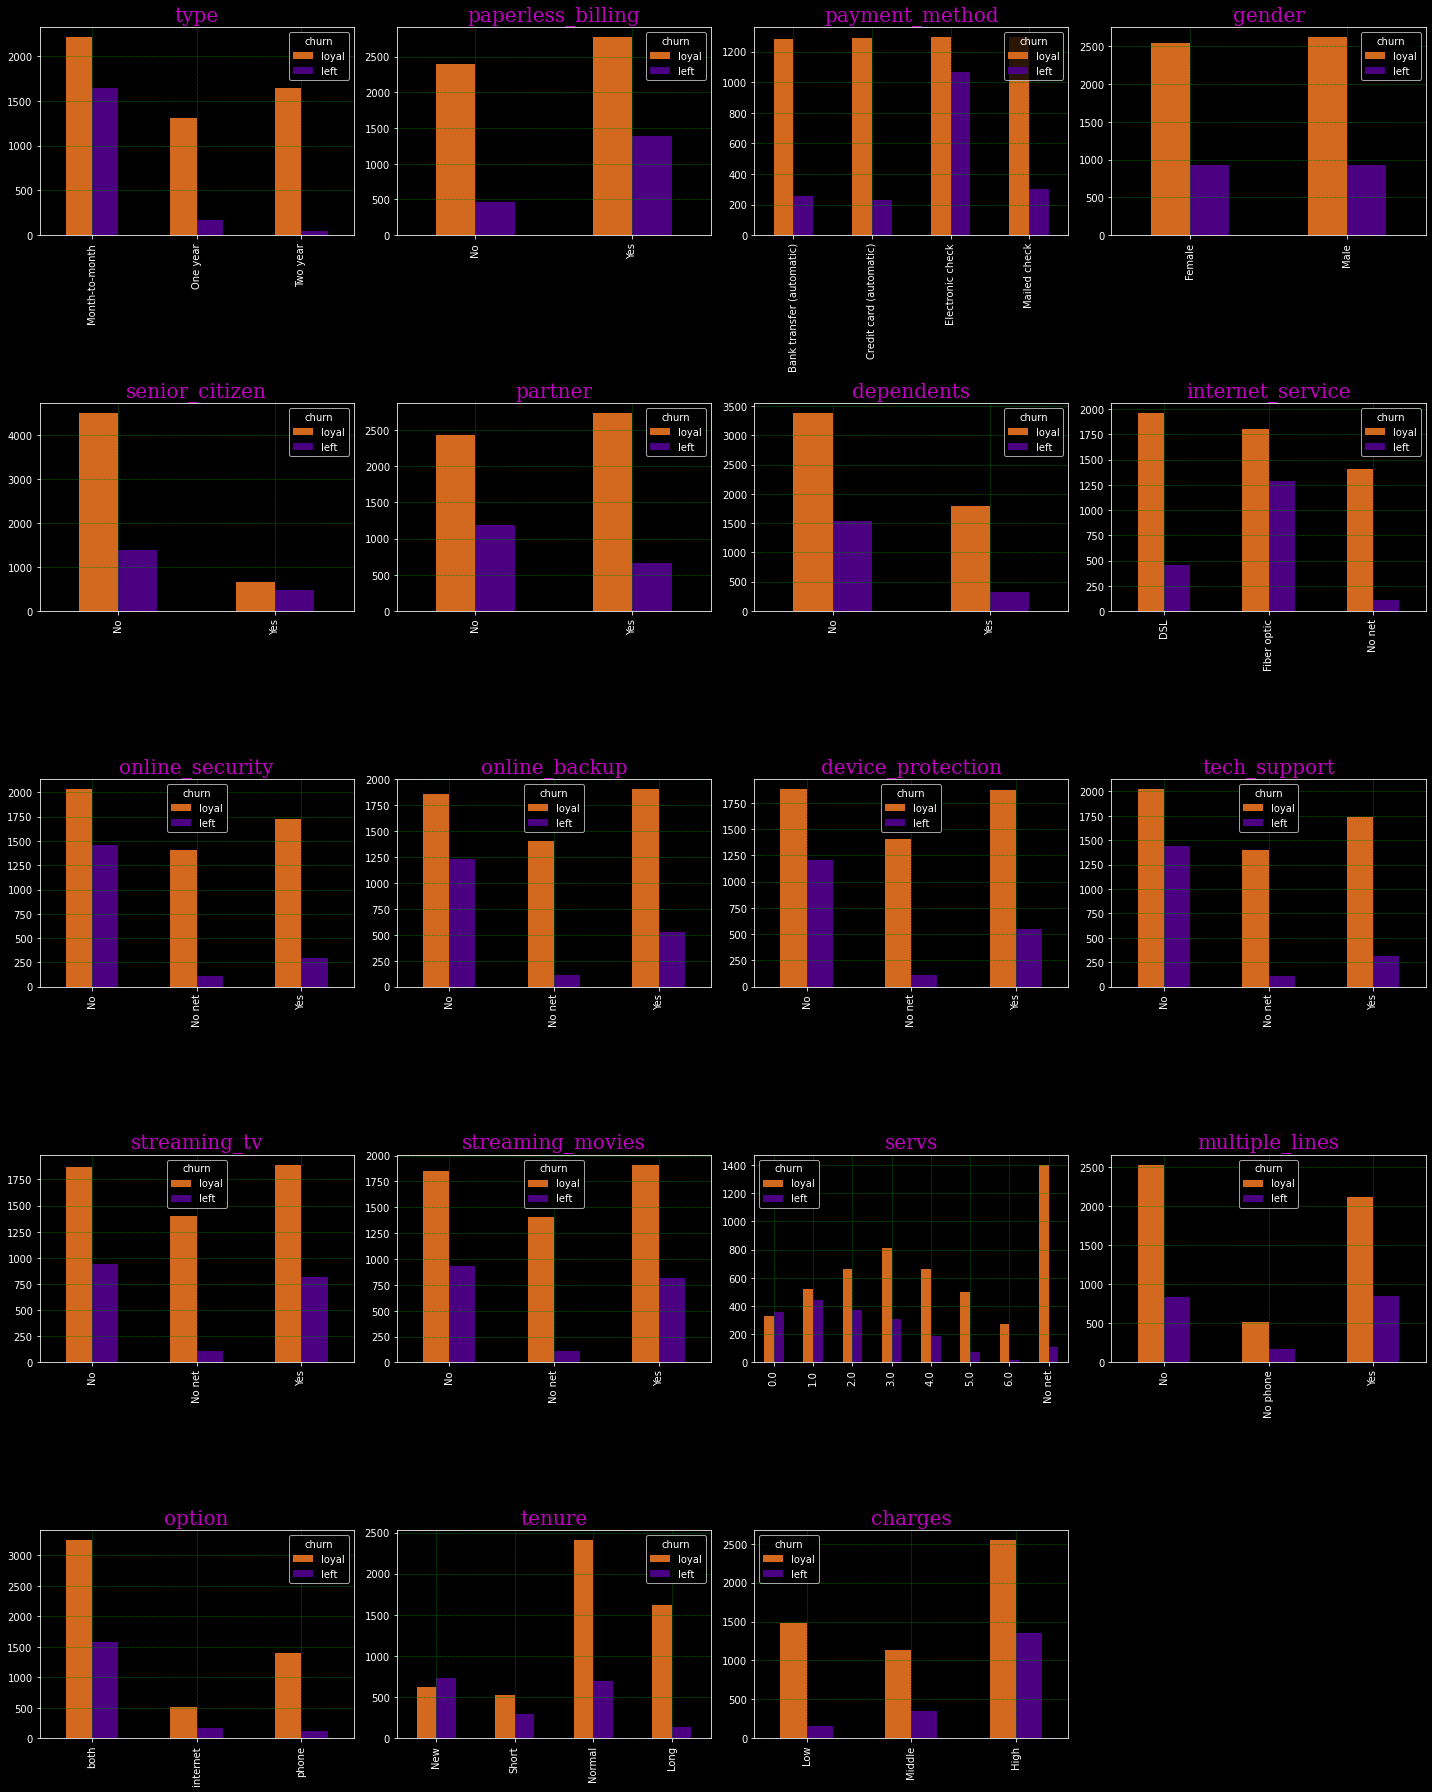

In [77]:
# barplots for category_features group by count

for idx, column in enumerate(category_features):

    # features group by count
    grouped_df = telecom.groupby([column, 'churn'])['churn'].count()
    grouped_df = grouped_df.unstack()
    grouped_df = grouped_df.rename(columns={0:'loyal', 1:'left'})

    # colors list
    colors = ['chocolate', 'indigo', 'orchid', 'yellowgreen']
    
    # barplot for grouped data
    ax = plt.subplot(5,4,idx+1)  
    grouped_df.plot.bar(ax=ax, figsize=(20,25), color=colors)
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

    # title style
    font = {'family':'serif','color':'m','size':20}
    plt.title(column, fontdict=font)
    plt.xlabel('')

    plt.tight_layout()

Категориальные признаки, в общем случае, принимают следующие значения:
* Тип оплаты у клиентов преобладает "ежемесячный", при этом у ушедших это выражено ярче.
* Клиенты предпочитают безналичный расчет.
* Женский и мужской пол представлен практически одинаково.
* Пенсионеров заметно меньше у всех клиентов.
* Ушедшие клиенты в основном "незамужние", у лояльных - другой семейный статус.
* Клиенты оператора в основном без детей.
* Лояльные клиенты предпочитают интернет по DSL, также отметим большую часть без услсуг интернета. Ушедшие выбирают более современное подключение через оптоволокно.
* Дополнительные опции цифровых услуг и телефонии не очень популярны у всех клиентов. Число интернет-сервисов у лояльных клиентов в среднем не превышает 3, ушедшие предпочитают одно.
* Большинство клиентов пользуется, и телефонией, и интернетом.
* Ушедшие клиенты хорошо представлены в категории "новички" и "высокие платежи".

Построим круговые диаграммы для проверки полученной статистики клиентов.

<Figure size 432x288 with 0 Axes>

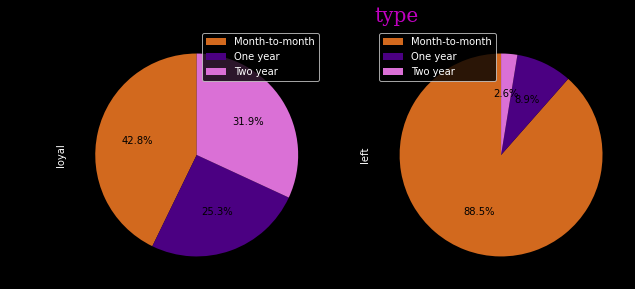

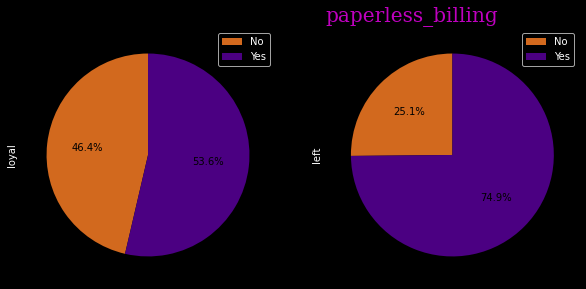

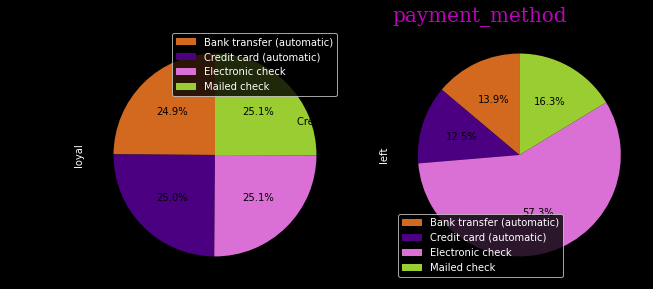

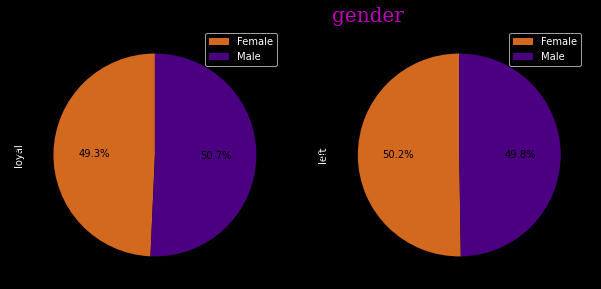

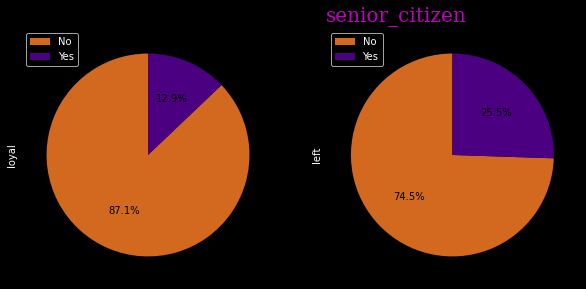

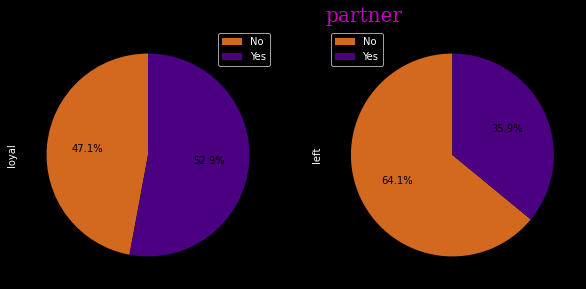

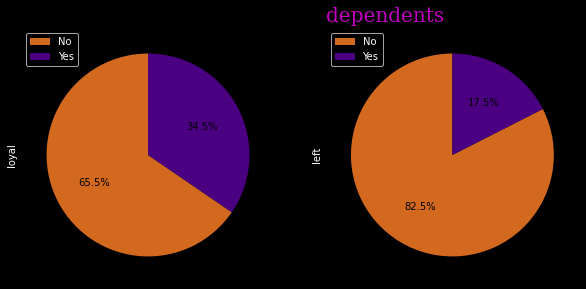

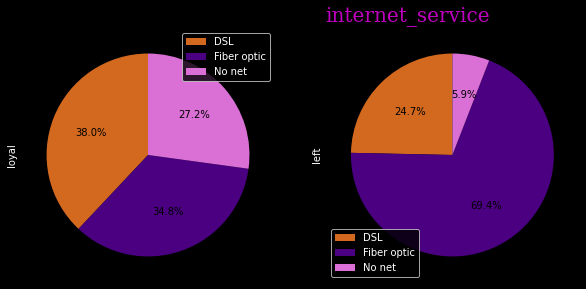

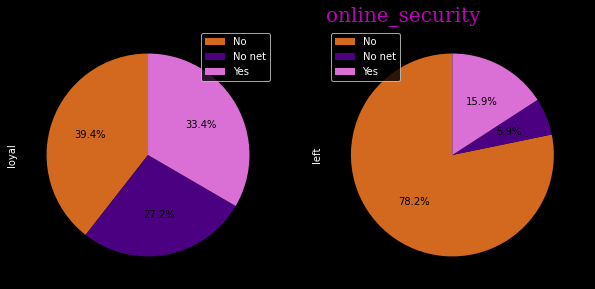

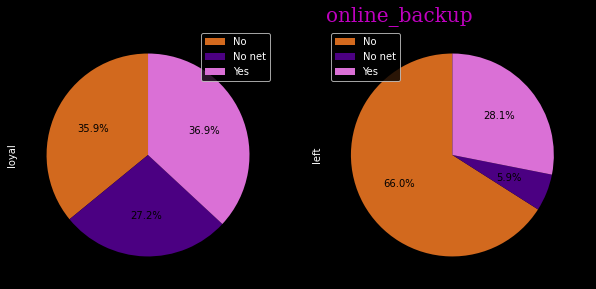

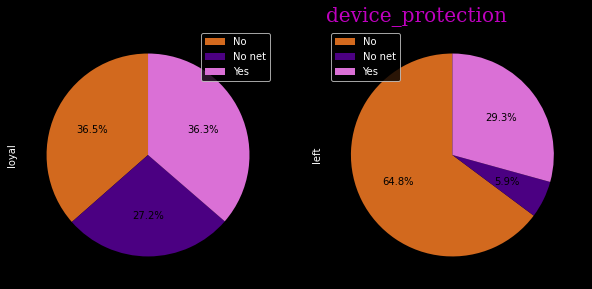

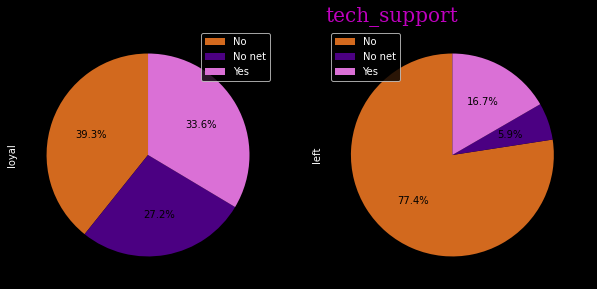

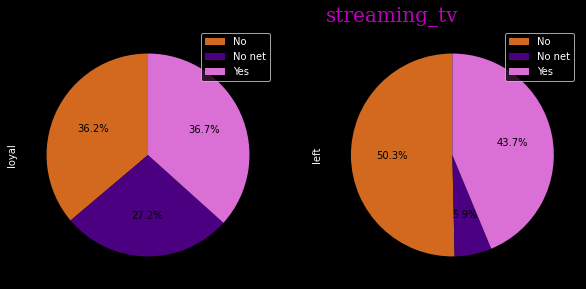

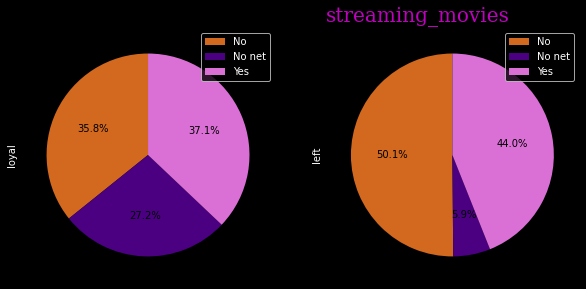

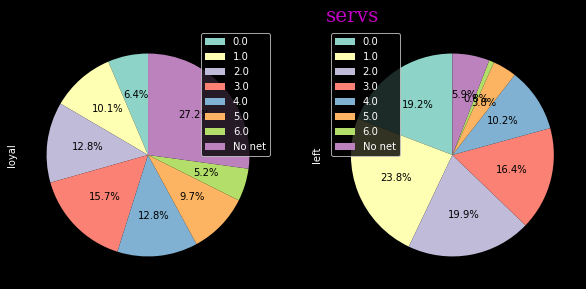

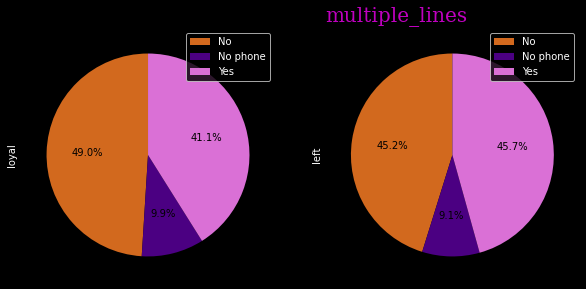

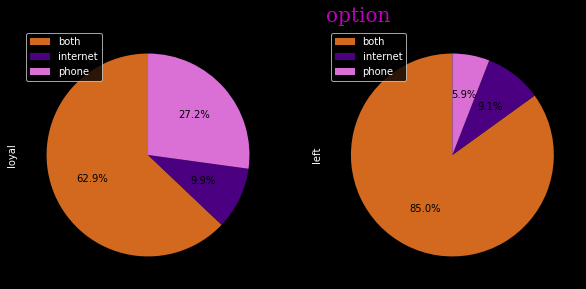

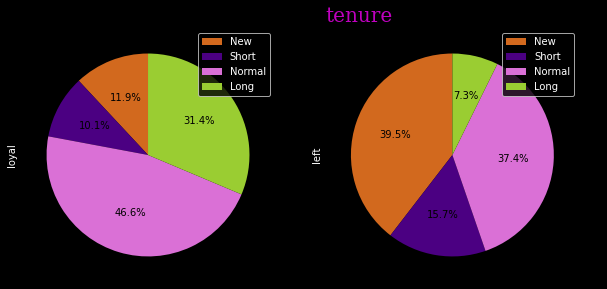

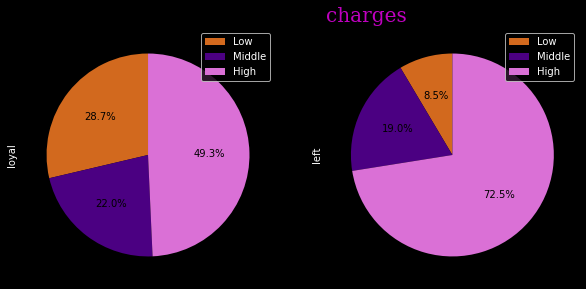

In [78]:
# pie plots for category_features group by count

for idx, column in enumerate(category_features):

    # features group by count
    grouped_df = telecom.groupby([column, 'churn'])['churn'].count()
    grouped_df = grouped_df.unstack()
    grouped_df = grouped_df.rename(columns={0:'loyal', 1:'left'})
    
    # pie plot for grouped data
    if column != 'servs' :
        plt.figure(idx)
        grouped_df.plot(kind='pie', autopct='%.1f%%', subplots=True, 
                        startangle = 90, legend=True,  textprops={'color':"black"}, 
                        colors=colors, figsize=(10,10))
        
    else:
        plt.figure(idx)
        grouped_df.plot(kind='pie', autopct='%.1f%%', subplots=True, 
                        startangle = 90, legend=True,  textprops={'color':"black"},figsize=(10,10))
    
    # title style
    font = {'family':'serif','color':'m','size':20}
    plt.title(column, loc='left', fontdict=font)
    plt.legend(loc='best');

Категориальные признаки, в общем случае, принимают следующие значения:
* Тип оплаты у клиентов преобладает "ежемесячный", при этом у ушедших это выражено ярче.
* Клиенты предпочитают безналичный расчет, при этом у ушедших это выражено ярче.
* Женский и мужской пол представлен практически одинаково.
* Пенсионеров заметно меньше у всех клиентов.
* Ушедшие клиенты в основном "незамужние", у лояльных - другой семейный статус.
* Клиенты оператора в основном без детей, при этом у ушедших это выражено ярче.
* Лояльные клиенты предпочитают интернет по DSL, также отметим большую часть без услуг интернета. Ушедшие выбирают более современное подключение через оптоволокно.
* Дополнительные опции цифровых услуг и телефонии не очень популярны у всех клиентов. Число интернет-сервисов у лояльных клиентов в среднем не превышает 3, ушедшие предпочитают одно.
* Большинство клиентов пользуется, и телефонией, и интернетом.
* Ушедшие клиенты хорошо представлены в категории "новички" и "высокие платежи".

Статистика ушедших клиентов подтвердилась. Процентное соотношение круговых диаграмм совпадает с данными из столбчатых. Анализ категориальных признаков также выявил зависимость высоких ежемесячных платежей (около 73% клиентов) и уход в первые месяцы пользования (около 40% клиентов). На основе этих данных можно будет описать среднестатистический портрет уходящего клиента.

#### Динамика оттока клиентов

Построим графики для статистики прихода/оттока клиентов.

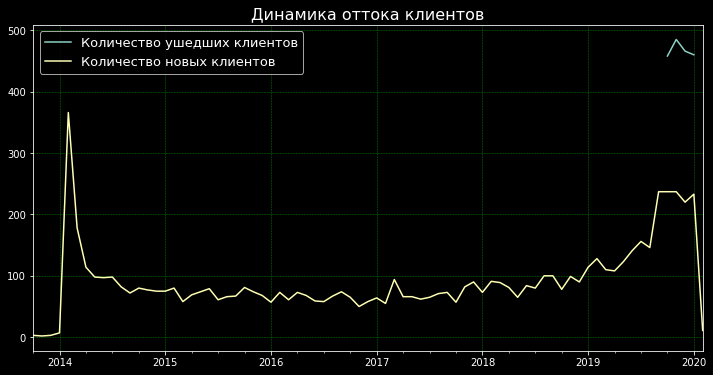

In [79]:
# plot of statistic clients

ax = contract.query('churn==1').groupby('end_date')['customer_id'].count().plot(figsize=(12,6))
ax = contract.groupby('begin_date')['customer_id'].count().plot()

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
ax.legend(['Количество ушедших клиентов', 'Количество новых клиентов'], fontsize=13)

plt.title('Динамика оттока клиентов', fontsize=16)

plt.xlabel('');

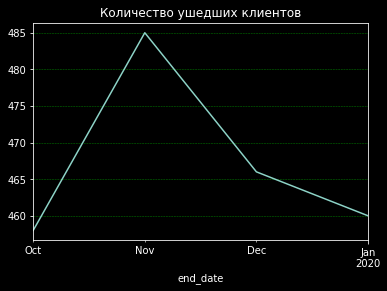

In [80]:
# plot of churn clients
contract.query('churn==1').groupby('end_date')['customer_id'].count().plot()

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.title('Количество ушедших клиентов');

Нам предоставлены данные клиентов, присоединившихся к оператору с 2014 года. Рассмотриим основные этапы, согласно графикам:
* Можно выделить большое количество подключенных (около 370) в начале 2014 года. 
* Приход новых клиентов резко снижается к середине года, и их количество колеблится в диапозоне от 70 до 100 до 2019 года. 
* Динамика прихода клиентов возрастает до значения 240 в 2019 году. 
* Отток клиентов начинается c октября 2019 года. Пик приходится на ноябрь. Количество ушедших примерно в 2 раза больше числа новых клиентов за этот период. Странно, что отток в данных прдеставлен только за этот период. 

#### Вывод

Ситуация для компании на рынке негативная. Мы видим значительное количество ушедших клиентов в последнее время. Необходимо провести мероприятия для удержания действующих и привлечения новых клиентов. 

Полученные результаты позволяют нам сделать портрет среднестатистического нелояльного клиента. Выделим его характерные черты:
* оплата ежемесячно по безналичномку расчету без автоплатежей;
* незамужний;
* интернет подключение через оптоволоконный кабель;
* подключена одна доп. услуга;
* высокие месячные платежи могут быть причиной ухода;
* суммарные платежи и распределение значений months говорит о большой вероятности ухода в первые месяцы пользования услугами оператора.

Использование дополнительных услуг, пенсионный статус, пол, а также наличие детей на лояльность клиентов особо не влияют. Возможно проблемы связаны с качеством или ценой предоставленных услуг, указанных в портрете нелояльного клиента. Оператору следует изучить их более детально.

Несмотря на то, что в данных отражен временной период с 2014 года, отток клиентов начинается только c октября 2019 года. Возможно выгрузка данных была прведена только частично. Необходимо уточнить этот момент у оператора.

## Подготовка данных

Выполненная ниже обработка данных поможет нам точнее и быстрее обучить модель.

### Проверка мультиколлинеарности

Мультиколлинеарность — корреляция независимых переменных, которая затрудняет оценку и анализ общего результата, т.е. мешает обучению модели.  Найдем коэффициент корреляции Пирсона — меру линейной связи числовых признаков в исходных данных.

In [81]:
# calculate the correlation between numeric features
telecom.corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,monthly_charges,total_charges,churn,months,days
monthly_charges,1.00,0.65,0.19,0.25,0.25
total_charges,0.65,1.00,-0.20,0.83,0.83
churn,0.19,-0.20,1.00,-0.35,-0.35
months,0.25,0.83,-0.35,1.00,1.00
days,0.25,0.83,-0.35,1.00,1.00


Можно сказать о наличии сильной корреляции между признаками months, days и total_charges, коэффициент Пирсона для них близок к 1. Чем дольше клиент пользуется услугами оператора, тем больше его суммарные расходы. Уберем из данных признак, касающий оплат клиента total_charges. Совокупность столбцов по типам услуг и количество дней контракта будут косвенно подсказывать модели о таких платежах.

Сильная связь между признаками months и days предсказуема, т.к. они рассчитаны от единого параметра - длительность контракта. Признак months получен синтетически, его тоже можно убрать в пользу days. Длительность в днях наиболее точно описывает этот признак.



In [82]:
# remove the features with correlation 
telecom_upd = telecom.drop(['months', 'total_charges'], axis=1 )

Найдем коэффициент корреляции с помощью библиотеки phik — определим меру нелинейной связи между признаками в исходных данных. Определим список числовых признаков как interval_cols. Посчитаем коэффициенты корреляции для признаков и построим тепловую карту. В данных заменим значения 'No net' и 'No phone' на 'No', т.к. анализ был выполнен и больше не нужно выделять подобные особенности.

In [83]:
telecom_upd = telecom_upd.replace({'No net': 'No', 'No phone': 'No' })

In [84]:
# phik matrix
phik_overview = telecom_upd.phik_matrix(interval_cols=numeric_features)

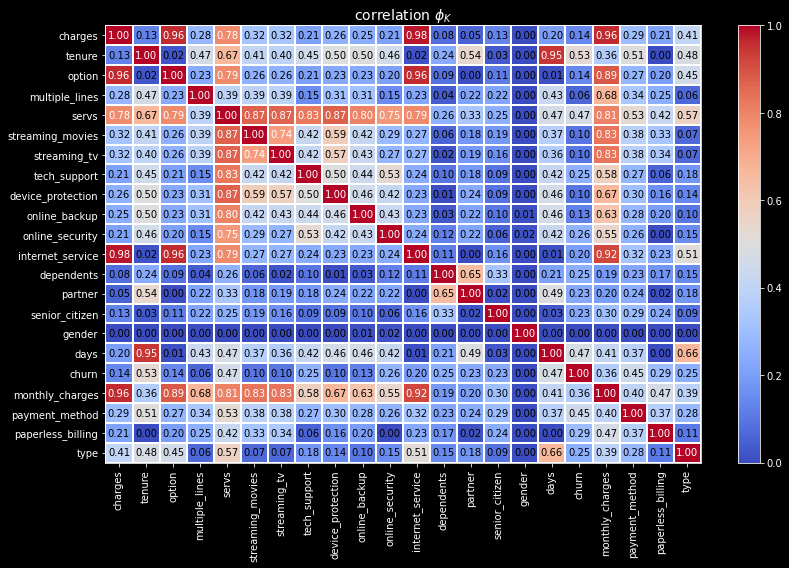

In [85]:
# heatmap of phik results

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(12, 8))
plt.tight_layout()

Рассмотрим распределение значений коэффициентов корреляции:

* Обнаружена сильная связь между признаками monthly_charges, charges и internet_service, а также между monthly_charges и другими цифровыми услугами оператора streaming_tv, streaming_movies. Видимо месячные платежи зависят в наибольшей степени от стоимости интернет-услуг. 

* Также сильная корреалиция у синтетических признаков, т.к. они рассчитаны на основе исходных данных.

* Признак gender показываает нулевую корреалицию и dependents, partner слабо связаны с признаками. Они также могут помешать обучению модели.

* Целевой признак явно ни с чем не коррелирует. Отметим слабую связь с multiple_lines и gender.

При оценке корреляций следует обратить внимание не только на коэффициенты, но и на их статистическую значимость. Потому что в итоге большая корреляция может оказаться статистически незначимой, и наоборот. Найдем статистическую значимость корреляции с помощью библиотеки phik.

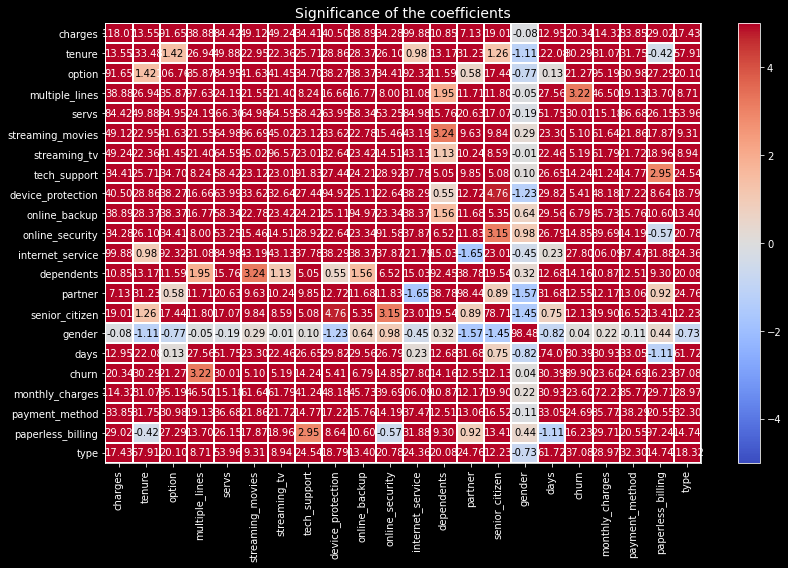

In [86]:
# phik significance matrix
significance_overview = telecom_upd.significance_matrix(interval_cols=numeric_features)

# heatmap of significance results
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, color_map="coolwarm", 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1, figsize=(12, 8))
plt.tight_layout()

Получены относительно высокие значения коэффициента для почти всех признаков, такие - статистически значимы. В то время как уровень значимости для "пол", "замужем" и "наличие детей" довольно низкий. Низкий уровень также у связи целевого признака с multiple_lines. Поэтому мы не можем довериться нулевым коэффициентам корреляции из прошлого анализа. Данные признаки остаются в данных.

Уберем из данных признаки, касающие оплат клиента monthly_charges. Совокупность столбцов по типам услуг оператора связи будет подсказывать модели о косвенных платежах. Также очистим данные от синтетических признаков.

Обновим данные и уберем мультикорреальные признаки, построим тепловую карту для проверки результата.

In [87]:
# remove the features with correlation 
telecom_final = telecom_upd.drop(['monthly_charges', 'option', 'charges', 'tenure', 'servs'], axis=1 )

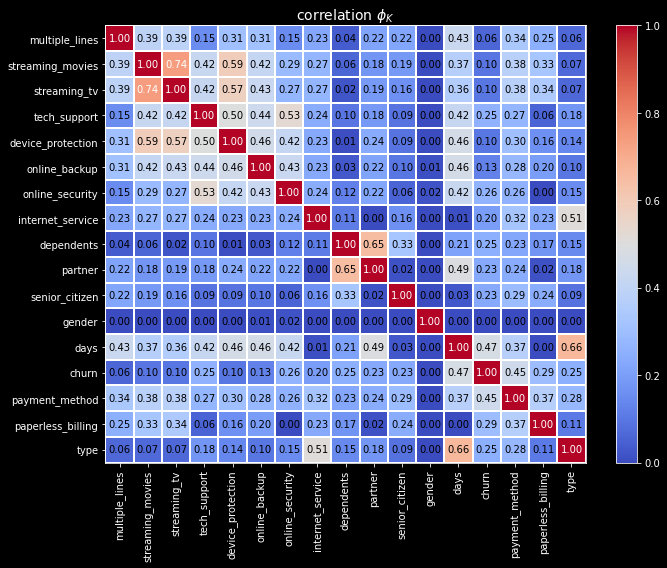

In [88]:
# updated phik matrix
phik_overview_upd = telecom_final.phik_matrix(interval_cols=numeric_features)

# heatmap of updated phik results
plot_correlation_matrix(phik_overview_upd.values, 
                        x_labels=phik_overview_upd.columns, 
                        y_labels=phik_overview_upd.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8))
plt.tight_layout()

Можно убедиться, что в обновленных данных нет определенной мультиколлинеарности признаков. Посмотрим на размер обновленных данных.

In [89]:
# data size
telecom_final.shape

(7025, 17)

Данные были сокращены на 7 признаков в результате проверки на мультиколлинеарность.

### Определение выборок

Тестовой выборки нет и валидационной также не будет, т.к. обучение будем проводить на кросс-валидации. Значит, данные нужно разбить на две части: обучающую и тестовую. Исходные данные разбиваем в соотношении 3:1. Зафиксируем псевдослучайность для алгоритма обучения, укажем параметр random_state. Необходимо учесть также, что в целевом признаке присутствует дисбаланс. Укажем параметр stratify, который сохранит пропорции классов (наблюдения класса 0 и наблюдения класса 1) для целевого признака во всех выборках.

In [90]:
# constant value
RANDOM_STATE = 290822

# definition of features and target
features = telecom_final.drop('churn', axis=1) 
target = telecom_final['churn']

# split data into train and test sets 
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                    random_state=RANDOM_STATE, stratify=target)

Проверим баланс классов. Убедимся, что определение выборок прошло корректно.

In [91]:
# balance of target classes
target_train.value_counts(normalize=True)

0    0.735004
1    0.264996
Name: churn, dtype: float64

In [92]:
# balance of target classes
target_test.value_counts(normalize=True)

0    0.735344
1    0.264656
Name: churn, dtype: float64

Дисбаланс сохранился в той же пропорции. Класс "1" встречается реже, доля составляет только 26.5%. 

Посмотрим на размер признаков полученных выборок.

In [93]:
print('Размер выборки для обучения:', features_train.shape)

Размер выборки для обучения: (5268, 16)


In [94]:
print('Размер выборки для теста:',features_test.shape)


Размер выборки для теста: (1757, 16)


Определение выборок прошло корректно.

### Кодирование признаков

Признаки содержат категориальные переменные. Для кодирования таких признаков и перевода в количественные переменные подходит техника прямого кодирования OHE (One-Hot Encoding). Она подходит для решения нашей задачи: работает со всеми моделями. Вызовем функцию pd.get_dummies с аргументом `drop_first=True`, чтобы не попасть в дамми-ловушку.

In [95]:
# OHE encoding
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
features_train_ohe.head()

,days,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_Yes,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
1531,1067,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1
3061,699,0,0,1,0,1,0,1,1,0,0,1,0,0,1,1,0,1,1,1
1576,2071,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0
5219,31,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
1790,365,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


Кодирование прошло корректно.  Выведем размер датасета после кодирования.

In [96]:
# data size
features_train_ohe.shape

(5268, 20)

Количество признаков увеличилось на 4 после ОНЕ кодирования.

### Масштабирование признаков

Значения признаков имеют разную размерность: days в тысячах, остальные до 1. Чтобы алгоритмам было легче обучать модели, признаки приводятся к одному масштабу.

In [97]:
pd.options.mode.chained_assignment = None

numeric = ['days']

# scaled data
features_train_scld = features_train_ohe.copy()
features_test_scld = features_test_ohe.copy()

# fit scaler on train data
scaler = StandardScaler()
scaler.fit(features_train_scld[numeric])

# scaling of features
features_train_scld[numeric] = scaler.transform(features_train_scld[numeric])
features_test_scld[numeric] = scaler.transform(features_test_scld[numeric])


features_train_scld.head()

,days,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_Yes,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
1531,0.110273,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1
3061,-0.384426,0,0,1,0,1,0,1,1,0,0,1,0,0,1,1,0,1,1,1
1576,1.459939,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0
5219,-1.282412,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
1790,-0.833419,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


Масштабирование прошло корректно.

Надо учесть, что данное преобразование неодназначно влияет на метрику качества моделей. Будем использовать полученную выборку features.._scld для эксперимента.

### Увеличение выборки

Сделаем объекты редкого класса не такими редкими в данных. Когда обучают модели, такая техника называется upsampling. Данная техника поможет увеличить положительный класс целевого признака. Преобразование проходит в несколько этапов:
* Разделить обучающую выборку на отрицательные и положительные объекты;
* Скопировать несколько раз положительные объекты;
* С учётом полученных данных создать новую обучающую выборку;
* Перемешать данные: идущие друг за другом одинаковые вопросы не помогут обучению.

Создадим для преобразования функцию `upsample` с тремя параметрами: features, target, repeat (количество повторений элементов положительного класса). Соотношение классов 1:3, попробуем repeat равный 2. Функция вернёт признаки и целевой признак после операции upsampling.

In [98]:
# function for upsampling

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=RANDOM_STATE)
    target_upsampled = shuffle(target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

# upsampling of train features and target
features_upsampled, target_upsampled = upsample(features_train_ohe, target_train, 2)

print(f'Размер увеличенной выборки для признаков: {features_upsampled.shape}')
print(f'Размер увеличенной выборки для целевого признака: {target_upsampled.shape}')
print()

# frequencies of unique values
print('Соотношение классов в увеличенной выборке:')
target_upsampled.value_counts(normalize=True)

Размер увеличенной выборки для признаков: (6664, 20)
Размер увеличенной выборки для целевого признака: (6664,)

Соотношение классов в увеличенной выборке:


0    0.581032
1    0.418968
Name: churn, dtype: float64

Функция корректно выполнила преобразование обучающих данных. Соотношение классов целевого признака изменилось.

### Алгоритм SMOTE

Увеличим количество объектов редкого класса с помощью алгоритма балансировки классов Smote (Synthetic Minority Oversampling Technique). В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы «похожи» на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировали их. Вызовем данный метод из библиотеке imblearn.

In [99]:
# smote upsampling features

sm = SMOTE(random_state=RANDOM_STATE)

features_smote, target_smote = sm.fit_resample(features_train_ohe, target_train)

# frequencies of unique values
print('Размер увеличенной выборки:', features_smote.shape)
print()
print('Соотношение классов в увеличенной выборке:')
target_smote.value_counts(normalize=True)

Размер увеличенной выборки: (7744, 20)

Соотношение классов в увеличенной выборке:


0    0.5
1    0.5
Name: churn, dtype: float64

Функция корректно выполнила преобразование обучающих данных. Соотношение классов целевого признака изменилось. Размер выборки больше чем у upsample на 1000 объектов.

## Обучение модели

### LightGBM

Рассмотрим модель классификации LightGBM. Обучим модель и оценим качество кросс-валидацией. Создадим функцию, где применим метод GridSearchCV, который выберет лучшие гиперпараметры для модели по заданной метрике ROC-AUC. Посчитаем ROC-AUC после обучения модели на полученных выборках.

In [100]:
# function for GridSearchCV best_params_

def grid_model(model, params, features, target):
    
    # GridSearchCV
    grid = GridSearchCV(model, param_grid = params, scoring='roc_auc', cv=5, n_jobs=-1)
    # GridSearchCV fit on train
    grid.fit(features, target)

    print('Гиперпараметры модели', grid.best_params_)
    print('ROC-AUC train:', grid.best_score_)
    return grid.best_params_

Определим список параметров модели для GridSearchCV.

In [101]:
# model parameters

params_LGBM = {'num_leaves': [3, 4, 5],
          'max_depth': [-1, -2, -3],
          'learning_rate': [0.6, 0.4, 0.5],
          'random_state': [RANDOM_STATE]}

Придадим объектам редкого класса больший вес. Алгоритмы машинного обучения считают все объекты обучающей выборки равнозначными по умолчанию. Необходимо указать, что какие-то объекты важнее, их классу присвоим вес. В модели есть аргумент is_unbalance. Применим параметр на сбалансирование, укажем is_unbalance='true'.

In [102]:
# model parameters with option unbalance

params_LGBM_blnc = {'num_leaves': [3, 4, 5],
          'max_depth': [-1, -2, -3],
          'learning_rate': [0.6, 0.4, 0.5],
          'is_unbalance': ['true'],
          'random_state': [RANDOM_STATE]}

Выполним GridSearchCV на кодированных признаках.

In [103]:
%%time

# GridSearchCV for features_train_ohe
best_params_LGBM_ohe = grid_model(LGBMClassifier(), params_LGBM, features_train_ohe, target_train)

Гиперпараметры модели {'learning_rate': 0.6, 'max_depth': -1, 'num_leaves': 5, 'random_state': 290822}
ROC-AUC train: 0.907807499974072
CPU times: user 597 ms, sys: 47.3 ms, total: 644 ms
Wall time: 7.55 s


Качество модели по метрике ROC-AUC приемлемое, больше 0.88.

Выполним GridSearchCV на кодированных признаках для сбалансированной модели.

In [104]:
%%time

# GridSearchCV for model with option unbalance
best_params_LGBM_blnc = grid_model(LGBMClassifier(), params_LGBM_blnc, features_train_ohe, target_train)

Гиперпараметры модели {'is_unbalance': 'true', 'learning_rate': 0.6, 'max_depth': -1, 'num_leaves': 5, 'random_state': 290822}
ROC-AUC train: 0.9069284928332271
CPU times: user 427 ms, sys: 28.8 ms, total: 456 ms
Wall time: 7.18 s


Качество модели по метрике ROC-AUC приемлемое, полученное значение чуть меньше чем у модели без опции сбалансирования.

Выполним GridSearchCV на масштабированных признаках.

In [105]:
%%time

# GridSearchCV for features_train_scld
best_params_LGBM_scld = grid_model(LGBMClassifier(), params_LGBM, features_train_scld, target_train)

Гиперпараметры модели {'learning_rate': 0.6, 'max_depth': -1, 'num_leaves': 5, 'random_state': 290822}
ROC-AUC train: 0.907807499974072
CPU times: user 444 ms, sys: 27.3 ms, total: 472 ms
Wall time: 7.16 s


Качество модели по метрике ROC-AUC приемлемое, такое же как на обучении кодированными признаками.

Выполним GridSearchCV на сбалансированных признаках.

In [106]:
%%time

# GridSearchCV for features_upsampled
best_params_LGBM_upsmpl = grid_model(LGBMClassifier(), params_LGBM, features_upsampled, target_upsampled)

Гиперпараметры модели {'learning_rate': 0.6, 'max_depth': -1, 'num_leaves': 5, 'random_state': 290822}
ROC-AUC train: 0.9343606114771106
CPU times: user 476 ms, sys: 35.7 ms, total: 512 ms
Wall time: 8.52 s


Качество модели по метрике ROC-AUC высокое, больше чем на обучении кодированными признаками.

Выполним GridSearchCV на сбалансированных признаках алгоритма SMOTE.

In [107]:
%%time

# GridSearchCV for features_smote
best_params_LGBM_smote = grid_model(LGBMClassifier(), params_LGBM, features_smote, target_smote)

Гиперпараметры модели {'learning_rate': 0.6, 'max_depth': -1, 'num_leaves': 5, 'random_state': 290822}
ROC-AUC train: 0.9526359621774523
CPU times: user 542 ms, sys: 40.4 ms, total: 582 ms
Wall time: 9.56 s


Качество модели по метрике ROC-AUC самое высокое среди рассмотренных моделей LGBMClassifier.

Сделаем сводную таблицу по результатам кросс-валидации.

In [108]:
pd.DataFrame({'модель':['LGBM. Upsample.','LGBM. OHE.', 'LGBM. Scaled.', 'LGBM. SMOTE.', 'LGBM-balanced'],
              'AUC-ROC.трейн':[0.9343, 0.9078, 0.9078, 0.9526, 0.9069],
              'скорость':['высокая', 'высокая', 'высокая', 'высокая', 'высокая']})

,модель,AUC-ROC.трейн,скорость
0,LGBM. Upsample.,0.9343,высокая
1,LGBM. OHE.,0.9078,высокая
2,LGBM. Scaled.,0.9078,высокая
3,LGBM. SMOTE.,0.9526,высокая
4,LGBM-balanced,0.9069,высокая


**Вывод**

Кросс-валидация на сбалансированных признаках алгоритма SMOTE дает самое высокое качество. Масштабирование признаков и сбалансирование модели не дает лучшего качества.

### CatBoost

Рассмотрим модель классификации CatBoost - бустинг для категориальных признаков. Обучим модель на выборке train и оценим качество кросс-валидацией с помощью полученной функции. 

In [109]:
# model parameters

params_CB = {'learning_rate': [0.08, 0.06, 0.1],
    'iterations': [50, 100],
    'l2_leaf_reg': [2, 3, 4],
    'depth': [5, 6, 4],
    'verbose':[0],
    'random_state':[RANDOM_STATE]}

Выполним GridSearchCV на кодированных признаках.

In [110]:
%%time

# GridSearchCV for features_smote
best_params_CB_ohe = grid_model(CatBoostClassifier(), params_CB, features_train_ohe, target_train)

Гиперпараметры модели {'depth': 5, 'iterations': 100, 'l2_leaf_reg': 2, 'learning_rate': 0.1, 'random_state': 290822, 'verbose': 0}
ROC-AUC train: 0.880633765402863
CPU times: user 1.43 s, sys: 213 ms, total: 1.64 s
Wall time: 57.6 s


Качество модели по метрике ROC-AUC приемлемое.

Выполним GridSearchCV на масштабированных признаках.

In [111]:
%%time

# GridSearchCV for features_train_scld
best_params_CB_scld = grid_model(CatBoostClassifier(), params_CB, features_train_scld, target_train)

Гиперпараметры модели {'depth': 5, 'iterations': 100, 'l2_leaf_reg': 2, 'learning_rate': 0.1, 'random_state': 290822, 'verbose': 0}
ROC-AUC train: 0.8805596728056395
CPU times: user 1.46 s, sys: 197 ms, total: 1.66 s
Wall time: 56 s


Качество модели по метрике ROC-AUC приемлемое, такое же как на обучение кодированными признаками.

Выполним GridSearchCV на сбалансированных признаках.

In [112]:
%%time

# GridSearchCV for features_upsampled
best_params_CB_upsmpl = grid_model(CatBoostClassifier(), params_CB, features_upsampled, target_upsampled)

Гиперпараметры модели {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 2, 'learning_rate': 0.1, 'random_state': 290822, 'verbose': 0}
ROC-AUC train: 0.9012020940226282
CPU times: user 1.68 s, sys: 234 ms, total: 1.91 s
Wall time: 1min 4s


Качество модели по метрике ROC-AUC высокое, больше чем на обучении кодированными признаками.

Выполним GridSearchCV на сбалансированных признаках алгоритма SMOTE.

In [113]:
%%time

# GridSearchCV for features_smote
best_params_CB_smote = grid_model(CatBoostClassifier(), params_CB, features_smote, target_smote)

Гиперпараметры модели {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 2, 'learning_rate': 0.1, 'random_state': 290822, 'verbose': 0}
ROC-AUC train: 0.9226720297645471
CPU times: user 1.93 s, sys: 172 ms, total: 2.1 s
Wall time: 1min 10s


Качество модели по метрике ROC-AUC самое высокое среди рассмотренных моделей CatBoostClassifier.

Обучим модель на выборке без кодирования features_train и оценим качество кросс-валидацией. Применим встроенный метод cv, который выберет для модели по заданной метрике лучшие гиперпараметры из нового списка params_Cat. Применим параметр на сбалансирование, укажем stratified=True.

In [114]:
# categorical features
cat_features = ['type', 'paperless_billing', 'payment_method', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']

In [115]:
# train_data for CatBoost
train_data = Pool(data=features_train,
                  label=target_train,
                  cat_features=cat_features)

In [116]:
# model
model_CB = CatBoostClassifier()

# model parameters
params_Cat = {'learning_rate': 0.01,
        'loss_function': 'Logloss',
          'eval_metric' : 'AUC',
        'depth': 5,
        'l2_leaf_reg': 2,
        'random_seed': RANDOM_STATE,
              'verbose':100}

In [117]:
%%time

# cross validation for Catboost

cv_data = cv(
    params = params_Cat,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False,
    early_stopping_rounds=100
)

Training on fold [0/5]

bestTest = 0.8761474654
bestIteration = 998

Training on fold [1/5]

bestTest = 0.8788877327
bestIteration = 994

Training on fold [2/5]

bestTest = 0.8818338844
bestIteration = 999

Training on fold [3/5]

bestTest = 0.8701156771
bestIteration = 999

Training on fold [4/5]

bestTest = 0.862028007
bestIteration = 999

CPU times: user 48.8 s, sys: 7.96 s, total: 56.8 s
Wall time: 33.8 s


Качество предсказаний по метрике ROC-AUC приемлимое, но не выше других моделей. Лучшая итерация близка к 1000, значит параметр learning_rate выбран верно.

Сделаем сводную таблицу по результатам кросс-валидации.

In [118]:
pd.DataFrame({'модель':['Catboost. OHE.', 'Catboost. Scaled.', 'Catboost. Upsample.', 'Catboost. SMOTE.', 'Catboost-balanced'],
              'AUC-ROC.трейн':[0.8813, 0.8813, 0.9015, 0.9201, 0.8818],
              'скорость':['средняя', 'средняя', 'средняя', 'средняя', 'высокая']})

,модель,AUC-ROC.трейн,скорость
0,Catboost. OHE.,0.8813,средняя
1,Catboost. Scaled.,0.8813,средняя
2,Catboost. Upsample.,0.9015,средняя
3,Catboost. SMOTE.,0.9201,средняя
4,Catboost-balanced,0.8818,высокая


**Вывод**

Кросс-валидация на сбалансированных признаках алгоритма SMOTE дает самое высокое качество. Масштабирование признаков и сбалансирование модели не дает лучшего качества.

### Вывод

Было определены следующие выборки:
* кодирование категорий - ..train_ohe, ..test_ohe.
* кодирование категорий, масштабирование признаков - ..train_scld, ..test_scld.
* кодирование категорий, увелеченная выборка - ..upsampled.
* кодирование категорий, увелеченная выборка SMOTE - ..smote.

Предсказание модели LightGBM наиболее точные на кросс-валидации по метрике ROC-AUC.

## Тестирование модели

### Анализ модели

Обучим модели с лучшими гиперпараметрами на всей тренировочной выборке и оценим качество их предсказаний на тесте по метрике ROC-AUC c помощью функции test.

In [119]:
# function for test model

def test(model, params, features_train, target_train, features_test, target_test):
    # model
    model_test = model(**params)
    # model training
    model_test.fit(features_train, target_train)
    # model predict
    return model_test.predict_proba(features_test)[:, 1] 

Проведем анализ моделей, посчитаем площадь под ROC-кривой. Эта кривая принимает значения целевого признака и вероятности положительного класса. Перебирает разные пороги и возвращает три списка: значения доли ложноположительных ответов FPR, значения доли истинно положительных ответов TPR и рассмотренные пороги.

Посчитаем AUC-ROC и построим ROC-кривую для каждой модели. Для модели, которая всегда отвечает случайно, ROC-кривая выглядит как прямая, идущая из левого нижнего угла в верхний правый.

LGBM. OHE. ROC-AUC test: 0.929
LGBM. Upsample. ROC-AUC test: 0.932
LGBM. SMOTE. ROC-AUC test: 0.912
LGBM-balanced. ROC-AUC test: 0.926


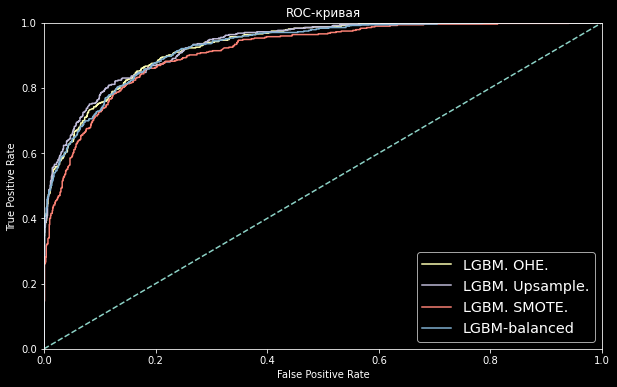

In [120]:
# ROC-curve for random model
plt.figure(figsize=[10,6])
plt.plot([0, 1], [0, 1], linestyle='--')

# test model for features_train_ohe
pred_proba_ohe = test(LGBMClassifier, best_params_LGBM_ohe, features_train_ohe, target_train, features_test_ohe, target_test)
roc_auc_ohe = roc_auc_score(target_test, pred_proba_ohe)

print(f'LGBM. OHE. ROC-AUC test: {roc_auc_ohe:.3}')

# ROC-curve of model for features_train_ohe
fpr, tpr, thresholds = roc_curve(target_test, pred_proba_ohe)
plt.plot(fpr, tpr,  label='LGBM. OHE.')

# test model for features_upsampled
pred_proba_upsmpl = test(LGBMClassifier, best_params_LGBM_upsmpl, features_upsampled, target_upsampled, features_test_ohe, target_test)
roc_auc_upsmpl = roc_auc_score(target_test, pred_proba_upsmpl)
print(f'LGBM. Upsample. ROC-AUC test: {roc_auc_upsmpl:.3}')

# ROC-curve of model for features_upsampled
fpr, tpr, thresholds = roc_curve(target_test, pred_proba_upsmpl)
plt.plot(fpr, tpr,  label='LGBM. Upsample.')

# test model for features_smote
pred_proba_smote = test(LGBMClassifier, best_params_LGBM_smote, features_smote, target_smote, features_test_ohe, target_test)
roc_auc_smote = roc_auc_score(target_test, pred_proba_smote)
print(f'LGBM. SMOTE. ROC-AUC test: {roc_auc_smote:.3}')

# ROC-curve of model for features_smote
fpr, tpr, thresholds = roc_curve(target_test, pred_proba_smote)
plt.plot(fpr, tpr,  label='LGBM. SMOTE.')

# test model with option unbalance
pred_proba_blnc = test(LGBMClassifier, best_params_LGBM_blnc, features_train_ohe, target_train, features_test_ohe, target_test)
roc_auc_blnc = roc_auc_score(target_test, pred_proba_blnc)
print(f'LGBM-balanced. ROC-AUC test: {roc_auc_blnc:.3}')

# ROC-curve of model with option unbalance
fpr, tpr, thresholds = roc_curve(target_test, pred_proba_blnc)
plt.plot(fpr, tpr,  label='LGBM-balanced')


# plot visual details

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.legend(loc='lower right', fontsize='x-large')
plt.show()

Модель на сбалансированных признаках методом upsampling показывает лучшее качество.

Выполним анализ важности признаков выбранной модели.

In [121]:
# fit LGBM with best parameters

model = LGBMClassifier(**best_params_LGBM_upsmpl)

model.fit(features_upsampled, target_upsampled)

LGBMClassifier(learning_rate=0.6, num_leaves=5, random_state=290822)

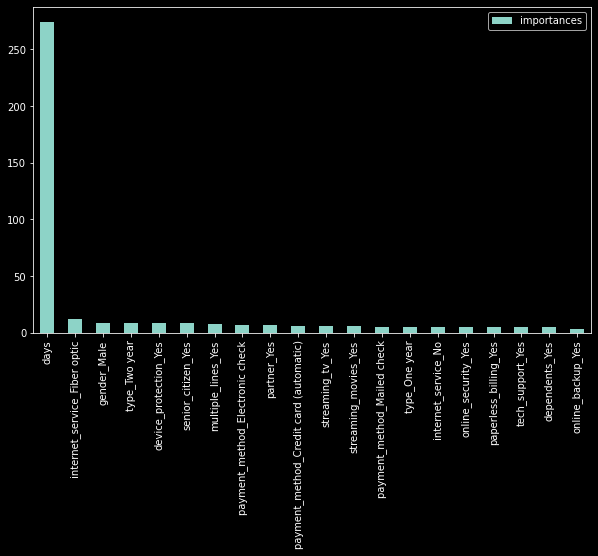

In [122]:
# feature_importance of LGBM

df_feature_importance = pd.DataFrame(model.feature_importances_, 
                                     index = features_train_ohe.columns, 
                                     columns=['importances']).sort_values(by='importances', ascending=False)


df_feature_importance.plot(kind='bar', figsize=[10,6]);

Признак длительность в днях оказывает наиболее сильное влияние на предсказание модели. Возможно такое доминирование обусловлено частичной утечкой целевого признака вследствие определенной выгрузки данных у Оператора (отток представлен только за 3 месяца).

Выполним анализ важности признаков без него.

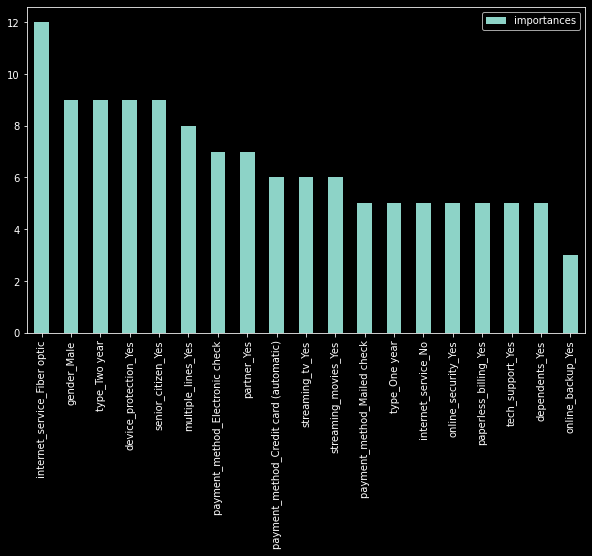

In [123]:
# feature_importance of LGBM without 'days'

df_feature_importance[1:].plot(kind='bar', figsize=[10,6]);

В этом случае важным признаком является - интернет подключение через оптоволоконный кабель. Видимо ушедшие клиенты были недовольны ценой или качеством интернет услуг от оператора.

Проверим качество модели на данных без признака длительности в днях.

In [124]:
# remove 'days' from features
features_upsampled_upd = features_upsampled.drop(['days'], axis=1)
features_test_upd = features_test_ohe.drop(['days'], axis=1)

In [125]:
%%time

# GridSearchCV for features_upd
best_params_LGBM_upd = grid_model(LGBMClassifier(), params_LGBM, 
                                  features_upsampled_upd, target_upsampled)

Гиперпараметры модели {'learning_rate': 0.4, 'max_depth': -1, 'num_leaves': 4, 'random_state': 290822}
ROC-AUC train: 0.8261779500151679
CPU times: user 441 ms, sys: 46 ms, total: 487 ms
Wall time: 8.67 s


In [126]:
# test model for features_upd
pred_proba_upd = test(LGBMClassifier, best_params_LGBM_upd, 
                      features_upsampled_upd, target_upsampled, 
                      features_test_upd, target_test)

roc_auc_upd = roc_auc_score(target_test, pred_proba_upd)
print(f'LGBM. Upsample. ROC-AUC test: {roc_auc_upd:.3}')

LGBM. Upsample. ROC-AUC test: 0.839


Качество модели без признака длительность в днях становится низким и неприемлемым.

### Утечка в данных

Подробнее изучим колонку "days". Сгруппируем данные по этому признаку, вычислим при каких значениях, клиенты уходили/оставались, найдем их долю в рамках полученной группы.

In [222]:
days = telecom.groupby(by='days')['churn'].agg(['sum', 'count'])
days['churn_share'] = round(days['sum'] / days['count'], 2)
days.sort_values(by=['sum'], ascending=False)

,sum,count,churn_share
days,,,
31,193,416,0.46
30,179,179,1.00
61,123,123,1.00
153,64,133,0.48
92,63,169,0.37
...,...,...,...
580,0,54,0.00
1676,0,55,0.00
1737,0,57,0.00


Имеется 156 групп значений для признака "days". Отметим, что в некоторых группах 100% пользователей ушло/осталось - это утечка данных. 

Присвоим каждой группе категорию: ушел, остался, не определено. Построим круговую диаграмму для этих категорий и найдем долю утечки. 

In [230]:
# category function
def category(value):
    
    if value == 0:
        return 'left'
    if value == 1:
        return 'loyal'
    return 'tbd' 

In [233]:
# apply function

days['category'] = days['churn_share'].apply(category)
days.head()

,sum,count,churn_share,category
days,,,,
0,0,11,0.00,left
30,179,179,1.00,loyal
31,193,416,0.46,tbd
61,123,123,1.00,loyal
62,0,115,0.00,left


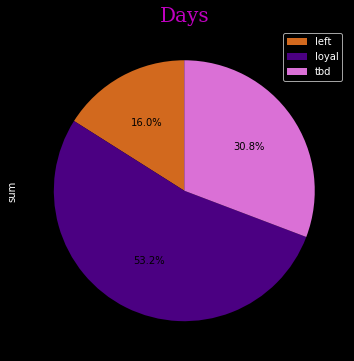

In [254]:
# gruop by category
grouped_df = days.groupby('category')['sum'].count()

# pie plot
grouped_df.plot(kind='pie', autopct='%.1f%%', startangle = 90, legend=True,  
                textprops={'color':"black"}, colors=colors, figsize=(6,6))

# title style
font = {'family':'serif','color':'m','size':20}
plt.title('Days', fontdict=font)
plt.legend(loc='best');

Мы видим утечку данных у 70% групп по дням. Вычислим долю утечки от общих данных.

In [264]:
share = days.query('category=="tbd"')['count'].sum() / telecom.shape[0]
print(f'Доля утечки в общих данных: {1 - share:.1%}')

Доля утечки в общих данных: 38.8%


Доля утечки в общих данных около 39%, поэтому мы получили высокую точность модели.

### CatBoost на обновленных данных

Обновим данные, уберем признак "days".

In [182]:
# remove the features with correlation 
telecom_final_upd = telecom.drop(['option', 'charges', 'days', 'servs',
                                  'tenure', 'total_charges', 
                                  'monthly_charges'], axis=1 )

In [267]:
# split data into train and test sets 
features_train_upd, features_test_upd, target_train_upd, target_test_upd = train_test_split(telecom_final_upd.drop(['churn'], axis=1), 
                                                                                            telecom_final_upd['churn'],  test_size=0.25, 
                                                                                            random_state=RANDOM_STATE, stratify=telecom_final_upd['churn'])


Применим метод Gridsearch со списком grid из  разных значений параметров количества деревьев и learning_rate'а.

In [184]:
# categorical features
cat_features_upd = ['type', 'paperless_billing', 'payment_method', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']

# train data for CV
train_data_upd = Pool(data=features_train_upd,
                  label=target_train_upd,
                  cat_features=cat_features_upd)

In [185]:
cv_classifer = CatBoostClassifier(loss_function = 'Logloss',
                                    random_state = RANDOM_STATE,
                                    eval_metric = 'AUC:hints=skip_train~false', #метрика, используемая для обнаружения переобучения
                                    bootstrap_type = 'Bayesian', # метод сэмплинга весов объектов
                                    verbose = False,
                                    early_stopping_rounds = 300,
                                    )

grid = {"iterations": [100, 200, 300, 500],
        "learning_rate":[0.03, 0.05],
        "max_depth": [2,4,6,8], 
        "grow_policy":['Lossguide'], 
        "min_data_in_leaf":[30, 50, 100, 150, 200], 
        "score_function": ['L2']} 

cb_grid_search = cv_classifer.grid_search(grid, X=train_data_upd)


bestTest = 0.8318037335
bestIteration = 99

0:	loss: 0.8318037	best: 0.8318037 (0)	total: 613ms	remaining: 1m 37s

bestTest = 0.8325271929
bestIteration = 95

1:	loss: 0.8325272	best: 0.8325272 (1)	total: 1.55s	remaining: 2m 2s

bestTest = 0.8344265608
bestIteration = 199

2:	loss: 0.8344266	best: 0.8344266 (2)	total: 4.09s	remaining: 3m 34s

bestTest = 0.836036545
bestIteration = 192

3:	loss: 0.8360365	best: 0.8360365 (3)	total: 5.22s	remaining: 3m 23s

bestTest = 0.8367875648
bestIteration = 287

4:	loss: 0.8367876	best: 0.8367876 (4)	total: 6.9s	remaining: 3m 34s

bestTest = 0.836036545
bestIteration = 192

5:	loss: 0.8360365	best: 0.8367876 (4)	total: 8.59s	remaining: 3m 40s

bestTest = 0.8373801124
bestIteration = 438

6:	loss: 0.8373801	best: 0.8373801 (6)	total: 11.4s	remaining: 4m 9s

bestTest = 0.8368197185
bestIteration = 483

7:	loss: 0.8368197	best: 0.8373801 (6)	total: 14.2s	remaining: 4m 29s

bestTest = 0.8345253188
bestIteration = 96

8:	loss: 0.8345253	best: 0.8373801

In [270]:
max(cb_grid_search['cv_results']['test-AUC-mean'])

0.8420183361474779

ROC-AUC на обучении 0.84. Параметры модели:

In [271]:
cb_grid_search['params']

{'min_data_in_leaf': 100,
 'depth': 4,
 'iterations': 200,
 'learning_rate': 0.05,
 'grow_policy': 'Lossguide',
 'score_function': 'L2'}

In [194]:
# model predict
cb_predict = cv_classifer.predict_proba(features_test_upd)[:, 1] 

# test model 
roc_auc_cb = roc_auc_score(target_test_upd, cb_predict)
print(f'CatBoost. ROC-AUC test: {roc_auc_cb:.3}')

CatBoost. ROC-AUC test: 0.86


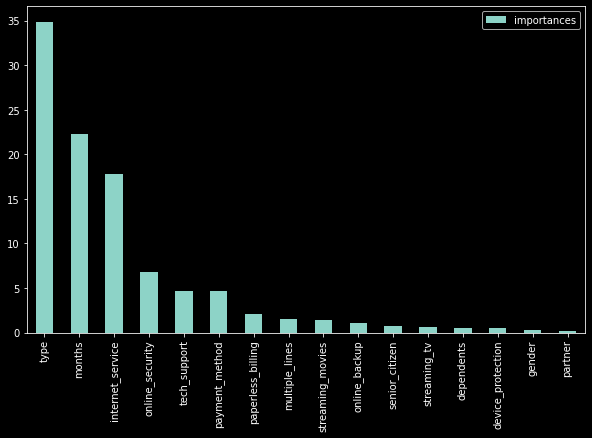

In [265]:
# feature_importance

df_feature_importance = pd.DataFrame(cv_classifer.feature_importances_, 
                                     index = features_train_upd.columns, 
                                     columns=['importances']).sort_values(by='importances', ascending=False)


df_feature_importance.plot(kind='bar', figsize=[10,6]);

Точность модели невысокая  0.86. Признак "type" оказывает наиболее сильное влияние на предсказание модели.

### Вывод

1) Сделаем сводную таблицу по результатам тестирования.

In [127]:
pd.DataFrame({'модель':['LGBM. Upsample.','LGBM. OHE.', 'LGBM. SMOTE.', 'LGBM-balanced'],
              'AUC-ROC.трейн':[0.9343, 0.9078, 0.9526, 0.9069],
              'AUC-ROC.тест':[roc_auc_upsmpl, roc_auc_ohe, roc_auc_smote, roc_auc_blnc],
              'скорость':['высокая', 'высокая', 'высокая', 'высокая']})

,модель,AUC-ROC.трейн,AUC-ROC.тест,скорость
0,LGBM. Upsample.,0.9343,0.931608,высокая
1,LGBM. OHE.,0.9078,0.928774,высокая
2,LGBM. SMOTE.,0.9526,0.911892,высокая
3,LGBM-balanced,0.9069,0.925952,высокая


Модель LGBM, обученная на кодированных признаках показывает наименьшее переобучение и примелимое качестве на тесте. Определим для этой модели основные метрики качества, в зависимости от порога: Точность, Полнота, Accuracy и f1.

In [128]:
# definition model metrics quality per threshold

for threshold in np.arange(0, 0.9, 0.1):
    predicted_valid = pred_proba_ohe > threshold
    
    result = f1_score(target_test, predicted_valid)       
    precision = precision_score(target_test, predicted_valid) 
    recall = recall_score(target_test, predicted_valid)
    score = accuracy_score(predicted_valid, target_test) 

    print("Порог = {:.2f} | f1 = {:.4f}, Точность = {:.3f}, Полнота = {:.3f}, Accuracy = {:.3f}".format(
        threshold, result, precision, recall, score))

Порог = 0.00 | f1 = 0.4185, Точность = 0.265, Полнота = 1.000, Accuracy = 0.265
Порог = 0.10 | f1 = 0.6418, Точность = 0.481, Полнота = 0.963, Accuracy = 0.715
Порог = 0.20 | f1 = 0.7102, Точность = 0.586, Полнота = 0.901, Accuracy = 0.805
Порог = 0.30 | f1 = 0.7328, Точность = 0.653, Полнота = 0.834, Accuracy = 0.839
Порог = 0.40 | f1 = 0.7370, Точность = 0.716, Полнота = 0.759, Accuracy = 0.857
Порог = 0.50 | f1 = 0.7315, Точность = 0.792, Полнота = 0.680, Accuracy = 0.868
Порог = 0.60 | f1 = 0.7029, Точность = 0.853, Полнота = 0.598, Accuracy = 0.866
Порог = 0.70 | f1 = 0.6564, Точность = 0.936, Полнота = 0.505, Accuracy = 0.860
Порог = 0.80 | f1 = 0.5474, Точность = 0.989, Полнота = 0.378, Accuracy = 0.834


Можно выделить оптимальное качество модели по основным метрикам при пороге 0.4.

2) Обнaружена утечка целевого признака в данных, признак "days". Доля составляет около 39%.

## Отчет исследования

### Введение

Оператор связи хочет научиться прогнозировать отток клиентов. Отдел маркетинга провел исследование и выяснил, что в последнее время из компании все чаще начали уходить клиенты к конкурентам. Стоимость маркетинговых затрат на возврат ушедшего клиента весьма высока, дешевле удержать клиента. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

**Цель исследования** 

Необходимо спрогнозировать, уйдёт клиент от оператора в ближайшее время или нет, т.е. построить модель для задачи классификации. Для оценки качества моделей применить метрику AUC-ROC. Значение метрики AUC-ROC должно быть больше 0.88.

**Ход исследования**

Команда оператора собрала и предоставила персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Информация о договорах актуальна на 1 февраля 2020. Прежде чем приступить к построению модели, мы проверили их на корректность.

Таким образом, исследование прошло по следующим намеченным этапам:
1. Открытие и анализ данных.
2. Подготовка данных.
3. Обучение моделей.
4. Анализ лучшей модели.

### Данные и определение признаков

Нам было предоставлен архив для 7043 клиентов внутри четырех файлов: информация о договоре, персональные данные клиента, информация об интернет-услугах и информация об услугах телефонии. В данных были обнаружены проблемы, которые мы разрешили, преобразовали информацию в форму более удобную для исследования. Выполненная обработка данных помогла нам точнее и быстрее обучить модель:
* Названия столбцов перезаписали с помощью "змеиного" регистра.
* Изменили тип данных c object на integer в total_charges. Заполнили пропуски значениями из monthly_charges.
* Отредактировали столбец end_date. Указали дату выгрузки данных 1 февраля 2020 для объектов со значение 'No'.
* Переведен тип данных столбцов begin_date и end_date в datetime.
* Посчитали длительность договора в месяцах и днях по разнице begin_date и end_date. В результате получены новые признаки months и days.
* Определили синтетические признаки на основе исходных данных клиентов - количество подключенных услуг, категории сервисов, по длительности договора и по платежам.
* Объеденили данные в общий датасет по следующим признакам: категориальные - type, paperless_billing, payment_method, gender, senior_citizen, partner, dependents, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines, servs, option, tenure, charges; числовые - monthly_charges, total_charges, months, days.
* Определили целевой признак churn, в который указали класс для каждого клиента на основе колонке end_date. Класс "0" - для значений 'No', класс "1" - для ушедших клиентов, значения с датой. 
* Признаки begin_date и end_date для обучения не нужны, т.к. они участвовали в вычислении длительности договора. Использование end_date приведет к утечке целевого признака. Колонку customer_id тоже убрали, она была необходима только для объединения данных.
* После объеденения данных были удалены явные дубликаты. Получена общая выборка размером (7025, 24).
* Выполнили проверку мультиколлинеарности признаков. Определили коэффициенты корреляции и статистической значимости с помощью библиотеки phik. Признаки 'monthly_charges', 'total_charges', а также все синтетические, кроме days, были убраны, как мультиколлинеарные. Получена общая выборка размером (7025, 17).

В результате предобработки и проверки на мультиколлинеарность был получен следующий список признаков для работы с моделями:
* churn - целевой признак, факт ухода клиента,
* days - длительность договора клиента в днях, 
* type – тип оплаты: ежемесячный, годовой и тд,
* paperless_billing – безналичный расчет,
* payment_method – способ оплаты,
* dependents – наличие иждивенцев,
* senior_citizen – наличие пенсионного статуса по возрасту,
* partner – наличие супруга(и),
* internet_service - подключение к интернету (DSL или оптоволоконный кабель);
* online_security - блокировка небезопасных сайтов, 
* online_backup - облачное хранилище файлов для резервного копирования данных, 
* device_protection - антивирус, 
* tech_support - выделенная линия технической поддержки, 
* streaming_tv - стриминговое телевидение, 
* streaming_movies - каталог фильмов,
* multiple_lines - подключение телефонного аппарата к нескольким линиям одновременно.

In [ ]:
telecom_final.head()

,type,paperless_billing,payment_method,churn,days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Month-to-month,Yes,Electronic check,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No
1,One year,No,Mailed check,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,1,61,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,Month-to-month,Yes,Electronic check,1,61,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


### Анализ данных

Ситуация для компании на рынке негативная. Мы видим значительное количество ушедших клиентов в последнее время. Необходимо провести мероприятия для удержания действующих и привлечения новых клиентов. 

Отток клиентов начинается c октября 2019 года. Пик приходится на ноябрь. Количество ушедших примерно в 2 раза больше числа новых клиентов за этот период. Несмотря на то, что в данных отражен временной период с 2014 года, отток клиентов начинается только c октября 2019 года. Возможно выгрузка данных была прведена только частично. Необходимо уточнить этот момент у Оператора.

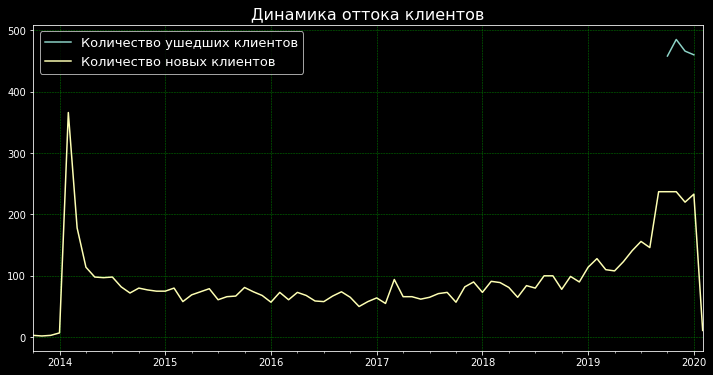

График charges показывает распределение значений по категориям ежемесячных платежей клиентов. Ушедшие клиенты "left" хорошо представлены в категории высоких платежей "high". Около 73% клиентов платили ежемесячно более 65 за пользование услугами оператора, когда у лояльных "loyal" эта доля составляет лишь 49.3%.

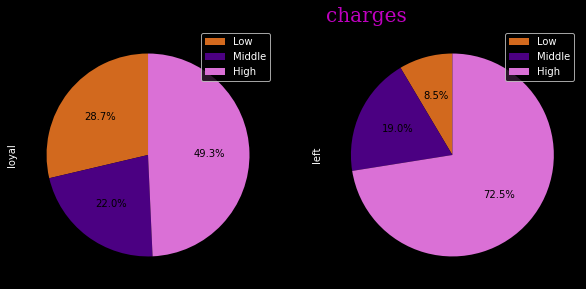

График tenure показывает распределение значений по категории длительности договора. Ушедшие клиенты "left" хорошо представлены в категории новых пользователей "New". Около 40% клиентов уходят от оператора в первые 5 месяцев пользования услугами, когда у лояльных "loyal" эта доля составляет лишь 11.9%.

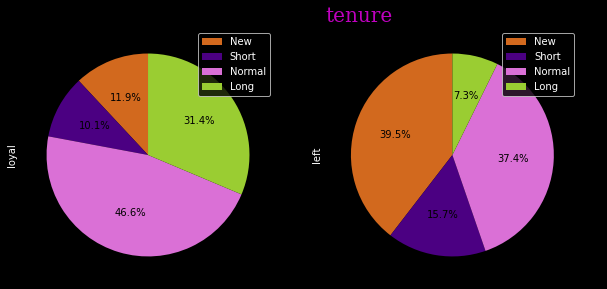

Полученные результаты исследования позволяют нам сделать портрет среднестатистического нелояльного клиента. Выделим его характерные черты:
* оплата ежемесячно по безналичномку расчету без автоплатежей;
* незамужний;
* интернет подключение через оптоволоконный кабель;
* подключена одна доп. услуга;
* высокие месячные платежи могут быть причиной ухода;
* большая вероятность ухода в первые месяцы пользования услугами оператора.

Использование дополнительных услуг, пенсионный статус, пол, а также наличие детей на лояльность клиентов особо не влияют. Возможно проблемы связаны с качеством или ценой предоставленных услуг, указанных в портрете нелояльного клиента. Оператору следует изучить их более детально.

### Обучение моделей


Обнаружен дисбаланс классов в данных. Класс "1" встречается реже, доля составляет только 26.5%. Рассмотрели представленные варианты решений проблемы дисбаланса: 
* оставить признаки с дисбалансом (пропорции граничного харктера 1:3);
* использовать метод семплирования, увеличить число объектов редкого класса;
* применить настройки модели для несбалансированной обучающей выборки.

Данные разбили на две части: обучающую для кросс-валидации и тестовую, в соотношении 3:1. Использовали параметр stratify для сохранения пропорции классов.

Были определены следующие выборки для кросс-валидации:
* кодирование категорий OHE.
* кодирование категорий, масштабирование признаков 
* кодирование категорий, увелеченная выборка методом Upsampling.
* кодирование категорий, увелеченная выборка с помощью алгоритма SMOTE.

Рассмотрели модели классификации из библиотеки градиентного бустинга LightGBM и CatBoost. Эти модели работают с категориальными признаками, показывают обычно высокие метрики качества, а также высокую скорость работы.

Определили лучшие гиперпараметры для моделей по заданной метрике ROC-AUC методом GridSearchCV. Кросс-валидация на сбалансированных признаках алгоритма SMOTE имеет самое высокое качество. Масштабирование признаков и сбалансирование модели не дает лучшего качества.

Предсказание модели LightGBM наиболее точные на кросс-валидации по метрике ROC-AUC.

In [ ]:
pd.DataFrame({'модель':['LGBM. Upsample.','LGBM. OHE.', 'LGBM. Scaled.', 'LGBM. SMOTE.', 'LGBM-balanced'],
              'AUC-ROC.трейн':[0.9343, 0.9078, 0.9078, 0.9526, 0.9069],
              'скорость':['высокая', 'высокая', 'высокая', 'высокая', 'высокая']})

,модель,AUC-ROC.трейн,скорость
0,LGBM. Upsample.,0.9343,высокая
1,LGBM. OHE.,0.9078,высокая
2,LGBM. Scaled.,0.9078,высокая
3,LGBM. SMOTE.,0.9526,высокая
4,LGBM-balanced,0.9069,высокая


In [ ]:
pd.DataFrame({'модель':['Catboost. OHE.', 'Catboost. Scaled.', 'Catboost. Upsample.', 'Catboost. SMOTE.', 'Catboost-balanced'],
              'AUC-ROC.трейн':[0.8813, 0.8813, 0.9015, 0.9201, 0.8818],
              'скорость':['средняя', 'средняя', 'средняя', 'средняя', 'высокая']})

,модель,AUC-ROC.трейн,скорость
0,Catboost. OHE.,0.8813,средняя
1,Catboost. Scaled.,0.8813,средняя
2,Catboost. Upsample.,0.9015,средняя
3,Catboost. SMOTE.,0.9201,средняя
4,Catboost-balanced,0.8818,высокая


### Анализ лучшей модели

Обучили модели с лучшими гиперпараметрами на всей тренировочной выборке и оценили качество их предсказаний на тесте по метрике ROC-AUC:
* LGBM. OHE. ROC-AUC test: 0.929
* LGBM. Upsample. ROC-AUC test: 0.932
* LGBM. SMOTE. ROC-AUC test: 0.912
* LGBM-balanced. ROC-AUC test: 0.926

Модель на сбалансированных признаках методом upsampling показало лучшее качество.

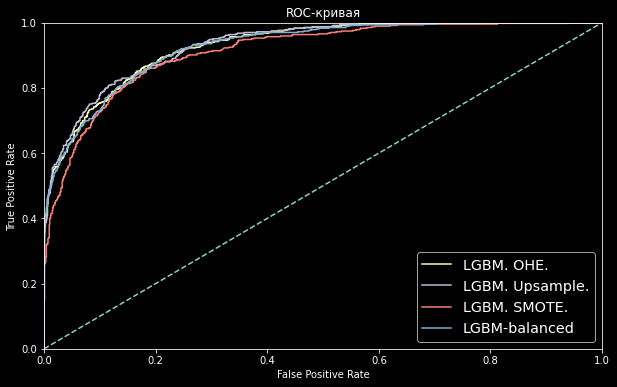

Модель LGBM, обученная на кодированных признаках показывает наименьшее переобучение и примелимое качестве на тесте. Эту модель следует рассмотреть в первую очередь для предсказания нелояльного клиента. Такую модель проще всего подготовить к работе, необходимо только кодирование признаков OHE.


Гиперпараметры модели: {'learning_rate': 0.6, 'max_depth': -1, 'num_leaves': 5, 'random_state': 290822}

In [ ]:
pd.DataFrame({'модель':['LGBM. OHE.'],
              'AUC-ROC.трейн':[ 0.9078],
              'AUC-ROC.тест':[ roc_auc_ohe],
              'скорость':[ 'высокая']})

,модель,AUC-ROC.трейн,AUC-ROC.тест,скорость
0,LGBM. OHE.,0.9078,0.928774,высокая


Оптимальные метрики качества для этой модели в зависимости от порога:
* Порог = 0.40 | f1 = 0.7370, Точность = 0.716, Полнота = 0.759, Accuracy = 0.857

Анализ важности признаков показал, что признак длительность в днях оказывает наиболее сильное влияние на предсказание модели. Такое доминирование обусловлено частичной утечкой целевого признака вследствие определенной выгрузки данных у Оператора (отток представлен только за 3 месяца). Качество модели без признака длительность в днях становится низким и неприемлемым. В этом случае следует повторно провести анализ признаков на мультиколлинеарность и определить данные для обучения.

Также важным признаком является - интернет подключение через оптоволоконный кабель. Видимо ушедшие клиенты были недовольны ценой или качеством интернет услуг от оператора.


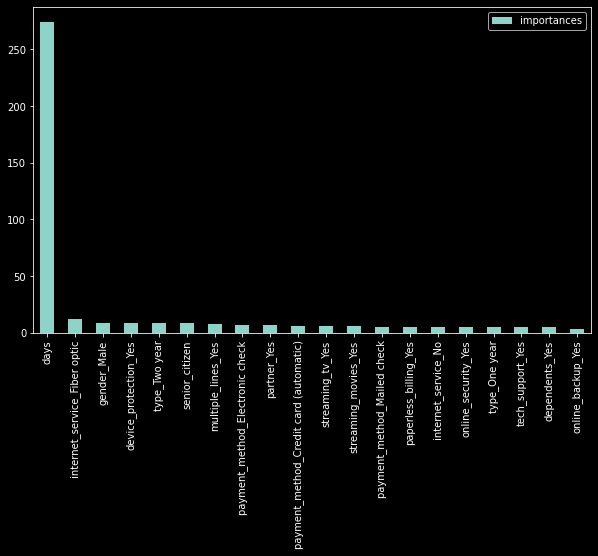

### Утечка целевого признака.

Обнaружена утечка целевого признака в данных, признак "days". Доля составляет: по группам значений - около 70%, от общих данных - около 39%. Выявленная особенность данных влияет на точность модели.

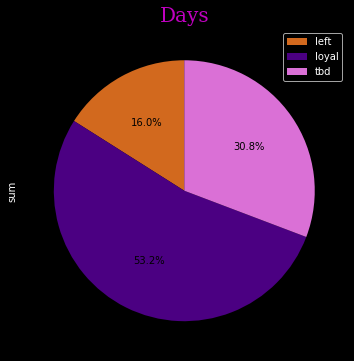

Выборки были обновлены с учетом утечки, признак "days" удален. Повторно проведен анализ модели.

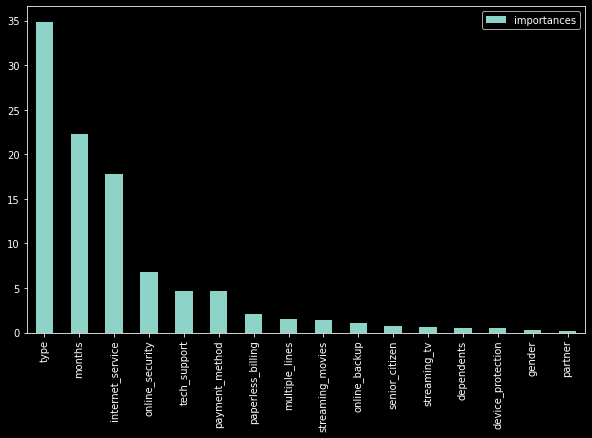

Качество модели по метрике ROC-AUC на тесте равно всего лишь 0.86. Предлагается повторно запросить данные для анализа. Возможно полученный архив был выгружен некоррректно.